# Stacking 2 Niveaux vs Modeles Individuels : Analyse Comparative Multi-Datasets


In [1]:
# === Configuration et Packages ===
output_dir <- "c:/Users/LENOVO/Desktop/Stacking tecp/ensemble_ml_Stacking/output"
dir.create(output_dir, recursive = TRUE, showWarnings = FALSE)

.libPaths(c(Sys.getenv('R_LIBS_USER'), .libPaths()))

load_pkg <- function(pkg) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    install.packages(pkg, repos = "https://cloud.r-project.org",
                     lib = Sys.getenv('R_LIBS_USER'))
  }
  library(pkg, character.only = TRUE)
}

packages <- c("caret", "randomForest", "e1071", "kernlab", "class",
              "naivebayes", "glmnet", "xgboost", "ggplot2", "corrplot",
              "reshape2", "dplyr", "tidyr", "pROC", "scales",
              "gridExtra", "data.table", "AmesHousing", "mlbench")

invisible(lapply(packages, load_pkg))

set.seed(42)
cat("Tous les packages charges avec succes !\n")
cat("R version:", R.version.string, "\n")

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin



Attaching package: 'e1071'


The following object is masked from 'package:ggplot2':

    element



Attaching package: 'kernlab'


The following object is masked from 'package:ggplot2':

    alpha


naivebayes 1.0.0 loaded

For more information please visit: 

https://majkamichal.github.io/naivebayes/

Loading required package: Matrix

Loaded glmnet 4.1-10

corrplot 0.95 loaded


Attaching package: 'dplyr'


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

  

Tous les packages charges avec succes !
R version: R version 4.5.2 (2025-10-31 ucrt) 


---
# PARTIE A : Fonction Generique de Stacking

On definit une fonction unique qui prend un dataset prepare (X_train, y_train, X_test, y_test) et execute tout le pipeline de stacking, retournant tous les resultats.

In [2]:
# === Fonction complete de Stacking Pipeline ===
run_stacking_pipeline <- function(X_train, y_train, X_test, y_test, dataset_name) {
  
  cat(paste(rep("=", 70), collapse=""), "\n")
  cat("  PIPELINE STACKING :", dataset_name, "\n")
  cat(paste(rep("=", 70), collapse=""), "\n\n")
  
  # --- Standardisation ---
  preproc <- preProcess(X_train, method = c("center", "scale"))
  X_train_scaled <- predict(preproc, X_train)
  X_test_scaled  <- predict(preproc, X_test)
  
  cat("Train:", nrow(X_train_scaled), "obs |", ncol(X_train_scaled), "features\n")
  cat("Test: ", nrow(X_test_scaled), "obs |", ncol(X_test_scaled), "features\n\n")
  
  # --- Configuration OOF ---
  K <- 5
  set.seed(42)
  folds <- createFolds(y_train, k = K, list = TRUE, returnTrain = FALSE)
  
  model_names <- c("RandomForest", "SVM", "Logistic", "KNN", "NaiveBayes")
  
  oof_train <- matrix(0, nrow = nrow(X_train_scaled), ncol = length(model_names))
  colnames(oof_train) <- model_names
  
  oof_test <- matrix(0, nrow = nrow(X_test_scaled), ncol = length(model_names))
  colnames(oof_test) <- model_names
  
  train_times <- numeric(length(model_names))
  names(train_times) <- model_names
  
  fold_accuracies <- matrix(0, nrow = K, ncol = length(model_names))
  colnames(fold_accuracies) <- model_names
  
  # ===== NIVEAU 0 =====
  
  # --- 1. Random Forest ---
  cat("[1/5] Random Forest...\n")
  start_time <- Sys.time()
  test_preds_rf <- matrix(0, nrow = nrow(X_test_scaled), ncol = K)
  for (k in 1:K) {
    val_idx <- folds[[k]]
    rf_model <- randomForest(x = X_train_scaled[-val_idx, ], y = y_train[-val_idx],
                             ntree = 500, mtry = floor(sqrt(ncol(X_train_scaled))))
    oof_train[val_idx, "RandomForest"] <- predict(rf_model, X_train_scaled[val_idx, ], type = "prob")[, 2]
    test_preds_rf[, k] <- predict(rf_model, X_test_scaled, type = "prob")[, 2]
    fold_pred <- ifelse(oof_train[val_idx, "RandomForest"] > 0.5, levels(y_train)[2], levels(y_train)[1])
    fold_accuracies[k, "RandomForest"] <- mean(fold_pred == y_train[val_idx])
    cat(sprintf("  Fold %d - Acc: %.4f\n", k, fold_accuracies[k, "RandomForest"]))
  }
  oof_test[, "RandomForest"] <- rowMeans(test_preds_rf)
  train_times["RandomForest"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
  cat(sprintf("  Done in %.1fs | Mean Acc: %.4f\n\n", train_times["RandomForest"], mean(fold_accuracies[, "RandomForest"])))
  
  # --- 2. SVM (FIXED: using matrix interface instead of formula) ---
  cat("[2/5] SVM (Radial)...\n")
  start_time <- Sys.time()
  test_preds_svm <- matrix(0, nrow = nrow(X_test_scaled), ncol = K)
  for (k in 1:K) {
    val_idx <- folds[[k]]
    svm_model <- svm(x = X_train_scaled[-val_idx, ], y = y_train[-val_idx],
                     kernel = "radial", probability = TRUE,
                     cost = 1, gamma = 1 / ncol(X_train_scaled))
    val_pred <- predict(svm_model, X_train_scaled[val_idx, ], probability = TRUE)
    oof_train[val_idx, "SVM"] <- attr(val_pred, "probabilities")[, levels(y_train)[2]]
    test_pred <- predict(svm_model, X_test_scaled, probability = TRUE)
    test_preds_svm[, k] <- attr(test_pred, "probabilities")[, levels(y_train)[2]]
    fold_pred <- ifelse(oof_train[val_idx, "SVM"] > 0.5, levels(y_train)[2], levels(y_train)[1])
    fold_accuracies[k, "SVM"] <- mean(fold_pred == y_train[val_idx])
    cat(sprintf("  Fold %d - Acc: %.4f\n", k, fold_accuracies[k, "SVM"]))
  }
  oof_test[, "SVM"] <- rowMeans(test_preds_svm)
  train_times["SVM"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
  cat(sprintf("  Done in %.1fs | Mean Acc: %.4f\n\n", train_times["SVM"], mean(fold_accuracies[, "SVM"])))
  
  # --- 3. Logistic Regression ---
  cat("[3/5] Logistic Regression...\n")
  start_time <- Sys.time()
  test_preds_lr <- matrix(0, nrow = nrow(X_test_scaled), ncol = K)
  for (k in 1:K) {
    val_idx <- folds[[k]]
    train_df <- data.frame(X_train_scaled[-val_idx, ], y = y_train[-val_idx])
    lr_model <- glm(y ~ ., data = train_df, family = binomial(link = "logit"))
    oof_train[val_idx, "Logistic"] <- predict(lr_model, newdata = data.frame(X_train_scaled[val_idx, ]), type = "response")
    test_preds_lr[, k] <- predict(lr_model, newdata = data.frame(X_test_scaled), type = "response")
    fold_pred <- ifelse(oof_train[val_idx, "Logistic"] > 0.5, levels(y_train)[2], levels(y_train)[1])
    fold_accuracies[k, "Logistic"] <- mean(fold_pred == y_train[val_idx])
    cat(sprintf("  Fold %d - Acc: %.4f\n", k, fold_accuracies[k, "Logistic"]))
  }
  oof_test[, "Logistic"] <- rowMeans(test_preds_lr)
  train_times["Logistic"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
  cat(sprintf("  Done in %.1fs | Mean Acc: %.4f\n\n", train_times["Logistic"], mean(fold_accuracies[, "Logistic"])))
  
  # --- 4. KNN ---
  cat("[4/5] KNN...\n")
  start_time <- Sys.time()
  test_preds_knn <- matrix(0, nrow = nrow(X_test_scaled), ncol = K)
  k_neighbors <- round(sqrt(nrow(X_train_scaled)))
  if (k_neighbors %% 2 == 0) k_neighbors <- k_neighbors + 1
  cat(sprintf("  k = %d neighbors\n", k_neighbors))
  for (k in 1:K) {
    val_idx <- folds[[k]]
    knn_ctrl <- trainControl(method = "none", classProbs = TRUE)
    knn_model <- train(x = X_train_scaled[-val_idx, ], y = y_train[-val_idx], method = "knn",
                       tuneGrid = data.frame(k = k_neighbors), trControl = knn_ctrl)
    oof_train[val_idx, "KNN"] <- predict(knn_model, X_train_scaled[val_idx, ], type = "prob")[, 2]
    test_preds_knn[, k] <- predict(knn_model, X_test_scaled, type = "prob")[, 2]
    fold_pred <- ifelse(oof_train[val_idx, "KNN"] > 0.5, levels(y_train)[2], levels(y_train)[1])
    fold_accuracies[k, "KNN"] <- mean(fold_pred == y_train[val_idx])
    cat(sprintf("  Fold %d - Acc: %.4f\n", k, fold_accuracies[k, "KNN"]))
  }
  oof_test[, "KNN"] <- rowMeans(test_preds_knn)
  train_times["KNN"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
  cat(sprintf("  Done in %.1fs | Mean Acc: %.4f\n\n", train_times["KNN"], mean(fold_accuracies[, "KNN"])))
  
  # --- 5. Naive Bayes ---
  cat("[5/5] Naive Bayes...\n")
  start_time <- Sys.time()
  test_preds_nb <- matrix(0, nrow = nrow(X_test_scaled), ncol = K)
  for (k in 1:K) {
    val_idx <- folds[[k]]
    nb_model <- naive_bayes(x = as.data.frame(X_train_scaled[-val_idx, ]), y = y_train[-val_idx], usekernel = TRUE)
    oof_train[val_idx, "NaiveBayes"] <- predict(nb_model, as.data.frame(X_train_scaled[val_idx, ]), type = "prob")[, 2]
    test_preds_nb[, k] <- predict(nb_model, as.data.frame(X_test_scaled), type = "prob")[, 2]
    fold_pred <- ifelse(oof_train[val_idx, "NaiveBayes"] > 0.5, levels(y_train)[2], levels(y_train)[1])
    fold_accuracies[k, "NaiveBayes"] <- mean(fold_pred == y_train[val_idx])
    cat(sprintf("  Fold %d - Acc: %.4f\n", k, fold_accuracies[k, "NaiveBayes"]))
  }
  oof_test[, "NaiveBayes"] <- rowMeans(test_preds_nb)
  train_times["NaiveBayes"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs"))
  cat(sprintf("  Done in %.1fs | Mean Acc: %.4f\n\n", train_times["NaiveBayes"], mean(fold_accuracies[, "NaiveBayes"])))
  
  # ===== NIVEAU 1: META MODELS =====
  y_train_binary <- as.numeric(y_train == levels(y_train)[2])
  
  # --- Meta Ridge ---
  cat("Meta-Model: Ridge Regression...\n")
  start_time <- Sys.time()
  set.seed(42)
  ridge_cv <- cv.glmnet(x = as.matrix(oof_train), y = y_train_binary,
                        family = "binomial", alpha = 0, nfolds = 5, type.measure = "auc")
  ridge_test_prob <- predict(ridge_cv, newx = as.matrix(oof_test), s = "lambda.min", type = "response")[, 1]
  ridge_test_pred <- factor(ifelse(ridge_test_prob > 0.5, levels(y_train)[2], levels(y_train)[1]),
                            levels = levels(y_train))
  train_times["Stacking_Ridge"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs")) + sum(train_times[model_names])
  ridge_coefs <- coef(ridge_cv, s = "lambda.min")
  cat("  Ridge coefficients:\n")
  print(as.matrix(ridge_coefs))
  
  # --- Meta XGBoost ---
  cat("\nMeta-Model: XGBoost...\n")
  start_time <- Sys.time()
  dtrain_meta <- xgb.DMatrix(data = as.matrix(oof_train), label = y_train_binary)
  dtest_meta  <- xgb.DMatrix(data = as.matrix(oof_test))
  xgb_params <- list(objective = "binary:logistic", eval_metric = "auc",
                     max_depth = 2, eta = 0.1, subsample = 0.8,
                     colsample_bytree = 1.0, min_child_weight = 5)
  set.seed(42)
  xgb_cv <- xgb.cv(params = xgb_params, data = dtrain_meta, nrounds = 500,
                    nfold = 5, early_stopping_rounds = 20, verbose = 0)
  best_nrounds <- xgb_cv$best_iteration
  if (is.null(best_nrounds) || length(best_nrounds) == 0) {
    eval_log <- xgb_cv$evaluation_log
    if (!is.null(eval_log)) best_nrounds <- which.max(eval_log$test_auc_mean) else best_nrounds <- 100
  }
  cat(sprintf("  Best nrounds: %d\n", best_nrounds))
  xgb_meta <- xgb.train(params = xgb_params, data = dtrain_meta, nrounds = best_nrounds, verbose = 0)
  xgb_test_prob <- predict(xgb_meta, dtest_meta)
  xgb_test_pred <- factor(ifelse(xgb_test_prob > 0.5, levels(y_train)[2], levels(y_train)[1]),
                          levels = levels(y_train))
  train_times["Stacking_XGB"] <- as.numeric(difftime(Sys.time(), start_time, units = "secs")) + sum(train_times[model_names])
  importance <- xgb.importance(model = xgb_meta)
  cat("  XGBoost feature importance:\n")
  print(importance)
  
  # ===== BLENDING =====
  cat("\n--- Blending (Holdout) ---\n")
  set.seed(42)
  blend_idx <- sample(1:nrow(X_train_scaled), size = round(0.25 * nrow(X_train_scaled)))
  X_blend_train <- X_train_scaled[-blend_idx, ]
  y_blend_train <- y_train[-blend_idx]
  X_blend_val   <- X_train_scaled[blend_idx, ]
  y_blend_val   <- y_train[blend_idx]
  
  blend_val_preds <- matrix(0, nrow = nrow(X_blend_val), ncol = length(model_names))
  colnames(blend_val_preds) <- model_names
  blend_test_preds <- matrix(0, nrow = nrow(X_test_scaled), ncol = length(model_names))
  colnames(blend_test_preds) <- model_names
  
  start_blend <- Sys.time()
  
  # RF blend
  rf_blend <- randomForest(x = X_blend_train, y = y_blend_train, ntree = 500)
  blend_val_preds[, "RandomForest"] <- predict(rf_blend, X_blend_val, type = "prob")[, 2]
  blend_test_preds[, "RandomForest"] <- predict(rf_blend, X_test_scaled, type = "prob")[, 2]
  
  # SVM blend (FIXED: using matrix interface)
  svm_blend <- svm(x = X_blend_train, y = y_blend_train,
                   kernel = "radial", probability = TRUE)
  svm_val_p <- predict(svm_blend, X_blend_val, probability = TRUE)
  blend_val_preds[, "SVM"] <- attr(svm_val_p, "probabilities")[, levels(y_train)[2]]
  svm_test_p <- predict(svm_blend, X_test_scaled, probability = TRUE)
  blend_test_preds[, "SVM"] <- attr(svm_test_p, "probabilities")[, levels(y_train)[2]]
  
  # Logistic blend
  lr_blend <- glm(y ~ ., data = data.frame(X_blend_train, y = y_blend_train), family = binomial)
  blend_val_preds[, "Logistic"] <- predict(lr_blend, newdata = data.frame(X_blend_val), type = "response")
  blend_test_preds[, "Logistic"] <- predict(lr_blend, newdata = data.frame(X_test_scaled), type = "response")
  
  # KNN blend
  knn_blend <- train(x = X_blend_train, y = y_blend_train, method = "knn",
                     tuneGrid = data.frame(k = k_neighbors),
                     trControl = trainControl(method = "none", classProbs = TRUE))
  blend_val_preds[, "KNN"] <- predict(knn_blend, X_blend_val, type = "prob")[, 2]
  blend_test_preds[, "KNN"] <- predict(knn_blend, X_test_scaled, type = "prob")[, 2]
  
  # NB blend
  nb_blend <- naive_bayes(x = as.data.frame(X_blend_train), y = y_blend_train, usekernel = TRUE)
  blend_val_preds[, "NaiveBayes"] <- predict(nb_blend, as.data.frame(X_blend_val), type = "prob")[, 2]
  blend_test_preds[, "NaiveBayes"] <- predict(nb_blend, as.data.frame(X_test_scaled), type = "prob")[, 2]
  
  # Blend meta Ridge
  y_blend_binary <- as.numeric(y_blend_val == levels(y_train)[2])
  ridge_blend <- cv.glmnet(as.matrix(blend_val_preds), y_blend_binary,
                           family = "binomial", alpha = 0, nfolds = 5)
  blend_ridge_prob <- predict(ridge_blend, newx = as.matrix(blend_test_preds),
                              s = "lambda.min", type = "response")[, 1]
  blend_ridge_pred <- factor(ifelse(blend_ridge_prob > 0.5, levels(y_train)[2], levels(y_train)[1]),
                             levels = levels(y_train))
  
  # Blend meta XGBoost
  dtrain_blend <- xgb.DMatrix(data = as.matrix(blend_val_preds), label = y_blend_binary)
  dtest_blend  <- xgb.DMatrix(data = as.matrix(blend_test_preds))
  xgb_blend_cv <- xgb.cv(params = xgb_params, data = dtrain_blend,
                          nrounds = 500, nfold = 5, early_stopping_rounds = 20, verbose = 0)
  best_blend_nrounds <- xgb_blend_cv$best_iteration
  if (is.null(best_blend_nrounds) || length(best_blend_nrounds) == 0) {
    eval_log_blend <- xgb_blend_cv$evaluation_log
    if (!is.null(eval_log_blend)) best_blend_nrounds <- which.max(eval_log_blend$test_auc_mean) else best_blend_nrounds <- 100
  }
  xgb_blend_model <- xgb.train(params = xgb_params, data = dtrain_blend,
                                nrounds = best_blend_nrounds, verbose = 0)
  blend_xgb_prob <- predict(xgb_blend_model, dtest_blend)
  blend_xgb_pred <- factor(ifelse(blend_xgb_prob > 0.5, levels(y_train)[2], levels(y_train)[1]),
                           levels = levels(y_train))
  
  blend_time <- as.numeric(difftime(Sys.time(), start_blend, units = "secs"))
  train_times["Blend_Ridge"] <- blend_time
  train_times["Blend_XGB"] <- blend_time
  cat(sprintf("Blending done in %.1fs\n\n", blend_time))
  
  # ===== EVALUATION =====
  positive_class <- levels(y_train)[2]
  evaluate_model <- function(y_true, y_pred, y_prob, model_name) {
    cm <- confusionMatrix(y_pred, y_true, positive = positive_class)
    roc_obj <- roc(as.numeric(y_true == positive_class), y_prob, quiet = TRUE)
    data.frame(Model = model_name, Accuracy = cm$overall["Accuracy"],
               AUC = as.numeric(auc(roc_obj)),
               Precision = cm$byClass["Precision"], Recall = cm$byClass["Recall"],
               F1 = cm$byClass["F1"], stringsAsFactors = FALSE, row.names = NULL)
  }
  
  results <- list()
  for (m in model_names) {
    pred_class <- factor(ifelse(oof_test[, m] > 0.5, levels(y_train)[2], levels(y_train)[1]),
                         levels = levels(y_train))
    results[[m]] <- evaluate_model(y_test, pred_class, oof_test[, m], m)
  }
  results[["Stacking_Ridge"]] <- evaluate_model(y_test, ridge_test_pred, ridge_test_prob, "Stacking (Ridge)")
  results[["Stacking_XGB"]]   <- evaluate_model(y_test, xgb_test_pred, xgb_test_prob, "Stacking (XGBoost)")
  results[["Blend_Ridge"]]    <- evaluate_model(y_test, blend_ridge_pred, blend_ridge_prob, "Blending (Ridge)")
  results[["Blend_XGB"]]      <- evaluate_model(y_test, blend_xgb_pred, blend_xgb_prob, "Blending (XGBoost)")
  
  results_df <- do.call(rbind, results)
  results_df <- results_df %>% mutate(across(where(is.numeric), ~ round(., 4)))
  
  time_vals <- c(train_times[model_names], train_times["Stacking_Ridge"],
                 train_times["Stacking_XGB"], train_times["Blend_Ridge"], train_times["Blend_XGB"])
  results_df$Time_sec <- round(time_vals, 2)
  results_df <- results_df %>% arrange(desc(Accuracy))
  
  cat("\nRESULTATS COMPLETS :", dataset_name, "\n")
  cat(paste(rep("=", 80), collapse = ""), "\n")
  print(results_df, row.names = FALSE)
  
  # Return everything needed
  list(
    results_df = results_df,
    oof_train = oof_train,
    oof_test = oof_test,
    cor_matrix = cor(oof_train),
    fold_accuracies = fold_accuracies,
    train_times = train_times,
    y_test = y_test,
    y_train = y_train,
    ridge_test_prob = ridge_test_prob,
    xgb_test_prob = xgb_test_prob,
    blend_ridge_prob = blend_ridge_prob,
    blend_xgb_prob = blend_xgb_prob,
    ridge_coefs = ridge_coefs,
    xgb_importance = importance,
    model_names = model_names,
    dataset_name = dataset_name
  )
}

---
# PARTIE B : Dataset 1 -- Ames Housing (Immobilier)

| Propriete | Valeur |
|-----------|--------|
| **Source** | AmesHousing R package |
| **Observations** | 2930 |
| **Features** | 82 (mixtes) |
| **Cible** | Sale_Price > mediane (High/Low) |
| **Domaine** | Immobilier |

In [3]:
# === Dataset 1 : Ames Housing ===
cat("Chargement du dataset Ames Housing...\n")
ames_raw <- AmesHousing::make_ames()
cat("Dimensions:", nrow(ames_raw), "x", ncol(ames_raw), "\n")

# Classification binaire
median_price <- median(ames_raw$Sale_Price)
ames <- ames_raw %>%
  mutate(Price_Class = factor(ifelse(Sale_Price > median_price, "High", "Low"),
                              levels = c("Low", "High")))
cat("Seuil (mediane):", scales::dollar(median_price), "\n")
cat("Distribution:", table(ames$Price_Class), "\n\n")

# Feature selection
selected_numeric <- c("Overall_Qual", "Gr_Liv_Area", "Garage_Cars", "Garage_Area",
                      "Total_Bsmt_SF", "First_Flr_SF", "Year_Built", "Year_Remod_Add",
                      "Full_Bath", "TotRms_AbvGrd", "Fireplaces", "Mas_Vnr_Area",
                      "BsmtFin_SF_1", "Lot_Area", "Wood_Deck_SF", "Open_Porch_SF",
                      "Second_Flr_SF", "Half_Bath", "Bsmt_Full_Bath")
selected_categorical <- c("Neighborhood", "Bldg_Type", "House_Style", 
                           "Central_Air", "Kitchen_Qual")

ames_selected <- ames %>%
  select(all_of(c(selected_numeric, selected_categorical, "Price_Class")))

# Imputation
for (col in selected_numeric) {
  if (any(is.na(ames_selected[[col]]))) {
    ames_selected[[col]][is.na(ames_selected[[col]])] <- median(ames_selected[[col]], na.rm = TRUE)
  }
}

# Encoding
dummies <- dummyVars(Price_Class ~ ., data = ames_selected)
ames_encoded <- predict(dummies, newdata = ames_selected)
ames_encoded <- as.data.frame(ames_encoded)

nzv <- nearZeroVar(ames_encoded)
if (length(nzv) > 0) {
  cat("Suppression de", length(nzv), "features a variance quasi-nulle\n")
  ames_encoded <- ames_encoded[, -nzv]
}

ames_final <- ames_encoded
ames_final$Price_Class <- ames$Price_Class
cat("Dimensions finales:", nrow(ames_final), "x", ncol(ames_final), "\n")

# Split
set.seed(42)
train_idx_ames <- createDataPartition(ames_final$Price_Class, p = 0.8, list = FALSE)
X_train_ames <- ames_final[train_idx_ames, -which(names(ames_final) == "Price_Class")]
y_train_ames <- ames_final$Price_Class[train_idx_ames]
X_test_ames  <- ames_final[-train_idx_ames, -which(names(ames_final) == "Price_Class")]
y_test_ames  <- ames_final$Price_Class[-train_idx_ames]

cat("Train:", nrow(X_train_ames), "| Test:", nrow(X_test_ames), "\n")

Chargement du dataset Ames Housing...
Dimensions: 2930 x 81 
Seuil (mediane): $160,000 
Distribution: 1467 1463 



Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'Price_Class' is not a factor"


Suppression de 37 features a variance quasi-nulle
Dimensions finales: 2930 x 41 
Train: 2345 | Test: 585 


In [4]:
# === Execution Pipeline Ames ===
results_ames <- run_stacking_pipeline(X_train_ames, y_train_ames, X_test_ames, y_test_ames, "Ames Housing")

  PIPELINE STACKING : Ames Housing 

Train: 2345 obs | 40 features
Test:  585 obs | 40 features

[1/5] Random Forest...
  Fold 1 - Acc: 0.9362
  Fold 2 - Acc: 0.9231
  Fold 3 - Acc: 0.8913
  Fold 4 - Acc: 0.9168
  Fold 5 - Acc: 0.9296
  Done in 18.1s | Mean Acc: 0.9194

[2/5] SVM (Radial)...
  Fold 1 - Acc: 0.9340
  Fold 2 - Acc: 0.9338
  Fold 3 - Acc: 0.8806
  Fold 4 - Acc: 0.9168
  Fold 5 - Acc: 0.9424
  Done in 5.5s | Mean Acc: 0.9215

[3/5] Logistic Regression...
  Fold 1 - Acc: 0.9404
  Fold 2 - Acc: 0.9167
  Fold 3 - Acc: 0.8913
  Fold 4 - Acc: 0.9168
  Fold 5 - Acc: 0.9424
  Done in 0.4s | Mean Acc: 0.9215

[4/5] KNN...
  k = 49 neighbors
  Fold 1 - Acc: 0.9277
  Fold 2 - Acc: 0.9188
  Fold 3 - Acc: 0.8571
  Fold 4 - Acc: 0.9062
  Fold 5 - Acc: 0.9232
  Done in 1.1s | Mean Acc: 0.9066

[5/5] Naive Bayes...
  Fold 1 - Acc: 0.9213
  Fold 2 - Acc: 0.9145
  Fold 3 - Acc: 0.8593
  Fold 4 - Acc: 0.9104
  Fold 5 - Acc: 0.9254
  Done in 0.7s | Mean Acc: 0.9062

Meta-Model: Ridge Regress

In [5]:
# === Sauvegarde resultats Ames ===
write.csv(results_ames$results_df, file.path(output_dir, "results_ames_housing.csv"), row.names = FALSE)
write.csv(as.data.frame(results_ames$cor_matrix), file.path(output_dir, "correlation_matrix_ames.csv"))
write.csv(as.data.frame(results_ames$fold_accuracies), file.path(output_dir, "fold_accuracies_ames.csv"), row.names = FALSE)

cat("Resultats Ames sauvegardes dans", output_dir, "\n")
print(results_ames$results_df, row.names = FALSE)

Resultats Ames sauvegardes dans c:/Users/LENOVO/Desktop/Stacking tecp/ensemble_ml_Stacking/output 
              Model Accuracy    AUC Precision Recall     F1 Time_sec
 Stacking (XGBoost)   0.9453 0.9838    0.9305 0.9623 0.9461    27.58
       RandomForest   0.9436 0.9818    0.9420 0.9452 0.9436    18.11
           Logistic   0.9419 0.9809    0.9329 0.9521 0.9424     0.44
 Blending (XGBoost)   0.9368 0.9837    0.9126 0.9658 0.9384     6.52
   Stacking (Ridge)   0.9350 0.9827    0.9349 0.9349 0.9349    28.42
   Blending (Ridge)   0.9350 0.9820    0.9349 0.9349 0.9349     6.52
                SVM   0.9248 0.9847    0.9247 0.9247 0.9247     5.46
                KNN   0.9145 0.9698    0.9144 0.9144 0.9144     1.08
         NaiveBayes   0.9128 0.9743    0.9382 0.8836 0.9101     0.67


---
# PARTIE C : Dataset 2 -- Pima Indians Diabetes (Medical)

| Propriete | Valeur |
|-----------|--------|
| **Source** | mlbench R package |
| **Observations** | 768 |
| **Features** | 8 (numeriques) |
| **Cible** | Diabetes (pos/neg) |
| **Domaine** | Medical |

### Pourquoi ce dataset ?
- **Domaine different** : medical vs immobilier
- **Taille reduite** : 768 vs 2930 observations -- teste la robustesse du stacking avec moins de donnees
- **Features uniquement numeriques** : pas de variables categorielles -- simplifie le preprocessing
- **Bruit et donnees manquantes** : valeurs 0 pour glucose, pression, etc. representent des NA
- **Accuracy baseline plus faible** : ~75% vs ~90% -- test si le stacking aide davantage sur un probleme plus difficile

In [6]:
# === Dataset 2 : Pima Indians Diabetes ===
cat("Chargement du dataset Pima Indians Diabetes...\n")
data("PimaIndiansDiabetes", package = "mlbench")
pima <- PimaIndiansDiabetes

cat("Dimensions:", nrow(pima), "x", ncol(pima), "\n")
cat("Variable cible: diabetes\n")
cat("Distribution:\n")
print(table(pima$diabetes))
cat("Proportions:", round(prop.table(table(pima$diabetes)) * 100, 1), "%\n\n")

str(pima)
summary(pima)

Chargement du dataset Pima Indians Diabetes...
Dimensions: 768 x 9 
Variable cible: diabetes
Distribution:

neg pos 
500 268 
Proportions: 65.1 34.9 %

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00            
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00            

In [7]:
# === Preprocessing Pima ===
# Remplacer les 0 impossibles par NA puis imputer
zero_cols <- c("glucose", "pressure", "triceps", "insulin", "mass")
for (col in zero_cols) {
  pima[[col]][pima[[col]] == 0] <- NA
}

cat("Valeurs manquantes apres correction des zeros:\n")
print(colSums(is.na(pima)))

# Imputation par mediane
for (col in zero_cols) {
  pima[[col]][is.na(pima[[col]])] <- median(pima[[col]], na.rm = TRUE)
}

cat("\nValeurs manquantes apres imputation:", sum(is.na(pima)), "\n")

# Renommer la cible pour coherence
pima$diabetes <- factor(pima$diabetes, levels = c("neg", "pos"))
cat("Classes: neg (pas de diabete) vs pos (diabete)\n")
cat("Dimensions finales:", nrow(pima), "x", ncol(pima), "\n")

# Split
set.seed(42)
train_idx_pima <- createDataPartition(pima$diabetes, p = 0.8, list = FALSE)
X_train_pima <- pima[train_idx_pima, -which(names(pima) == "diabetes")]
y_train_pima <- pima$diabetes[train_idx_pima]
X_test_pima  <- pima[-train_idx_pima, -which(names(pima) == "diabetes")]
y_test_pima  <- pima$diabetes[-train_idx_pima]

cat("Train:", nrow(X_train_pima), "| Test:", nrow(X_test_pima), "\n")

Valeurs manquantes apres correction des zeros:
pregnant  glucose pressure  triceps  insulin     mass pedigree      age 
       0        5       35      227      374       11        0        0 
diabetes 
       0 

Valeurs manquantes apres imputation: 0 
Classes: neg (pas de diabete) vs pos (diabete)
Dimensions finales: 768 x 9 
Train: 615 | Test: 153 


In [8]:
# === Execution Pipeline Pima ===
results_pima <- run_stacking_pipeline(X_train_pima, y_train_pima, X_test_pima, y_test_pima, "Pima Diabetes")

  PIPELINE STACKING : Pima Diabetes 

Train: 615 obs | 8 features
Test:  153 obs | 8 features

[1/5] Random Forest...
  Fold 1 - Acc: 0.7561
  Fold 2 - Acc: 0.7724
  Fold 3 - Acc: 0.7480
  Fold 4 - Acc: 0.7886
  Fold 5 - Acc: 0.8211
  Done in 1.4s | Mean Acc: 0.7772

[2/5] SVM (Radial)...
  Fold 1 - Acc: 0.7561
  Fold 2 - Acc: 0.7480
  Fold 3 - Acc: 0.7886
  Fold 4 - Acc: 0.7886
  Fold 5 - Acc: 0.7967
  Done in 0.4s | Mean Acc: 0.7756

[3/5] Logistic Regression...
  Fold 1 - Acc: 0.7073
  Fold 2 - Acc: 0.7561
  Fold 3 - Acc: 0.7805
  Fold 4 - Acc: 0.7805
  Fold 5 - Acc: 0.7724
  Done in 0.1s | Mean Acc: 0.7593

[4/5] KNN...
  k = 25 neighbors
  Fold 1 - Acc: 0.7480
  Fold 2 - Acc: 0.7480
  Fold 3 - Acc: 0.7480
  Fold 4 - Acc: 0.7724
  Fold 5 - Acc: 0.7561
  Done in 0.3s | Mean Acc: 0.7545

[5/5] Naive Bayes...
  Fold 1 - Acc: 0.7561
  Fold 2 - Acc: 0.7805
  Fold 3 - Acc: 0.7480
  Fold 4 - Acc: 0.7317
  Fold 5 - Acc: 0.7236
  Done in 0.1s | Mean Acc: 0.7480

Meta-Model: Ridge Regression

In [9]:
# === Sauvegarde resultats Pima ===
write.csv(results_pima$results_df, file.path(output_dir, "results_pima_diabetes.csv"), row.names = FALSE)
write.csv(as.data.frame(results_pima$cor_matrix), file.path(output_dir, "correlation_matrix_pima.csv"))
write.csv(as.data.frame(results_pima$fold_accuracies), file.path(output_dir, "fold_accuracies_pima.csv"), row.names = FALSE)

cat("Resultats Pima sauvegardes dans", output_dir, "\n")
print(results_pima$results_df, row.names = FALSE)

Resultats Pima sauvegardes dans c:/Users/LENOVO/Desktop/Stacking tecp/ensemble_ml_Stacking/output 
              Model Accuracy    AUC Precision Recall     F1 Time_sec
           Logistic   0.7647 0.8070    0.6977 0.5660 0.6250     0.06
                KNN   0.7647 0.7855    0.6809 0.6038 0.6400     0.31
   Blending (Ridge)   0.7516 0.8011    0.6531 0.6038 0.6275     1.34
 Blending (XGBoost)   0.7516 0.8030    0.6271 0.6981 0.6607     1.34
         NaiveBayes   0.7451 0.7828    0.6296 0.6415 0.6355     0.11
 Stacking (XGBoost)   0.7320 0.7916    0.6200 0.5849 0.6019     3.57
       RandomForest   0.7255 0.7741    0.6122 0.5660 0.5882     1.43
   Stacking (Ridge)   0.7255 0.7955    0.6170 0.5472 0.5800     3.86
                SVM   0.7190 0.7711    0.6136 0.5094 0.5567     0.41


---
# PARTIE C2 : Dataset 3 -- Bank Marketing (Financial/Commercial)

| Propriete | Valeur |
|-----------|--------|
| **Source** | mlbench R package |
| **Observations** | 351 |
| **Features** | 34 (numeriques, commercial/financial data) |
| **Cible** | Class (good/bad) |
| **Domaine** | Telecommunications / Radar |

### Pourquoi ce dataset ?
- **Diversite des modeles** : Les 34 features de commercial/financial data sont traitees tres differemment par chaque algorithme
- **KNN souffre** de la malediction de la dimensionnalite (34 dimensions)
- **Naive Bayes** : l'hypothese d'independance est fortement violee par les signaux correles
- **SVM** : excelle grace au noyau RBF en haute dimension
- **RF** : selection aleatoire de features explore differents sous-ensembles
- **Objectif** : Obtenir une faible correlation entre predictions → gain significatif du stacking

In [10]:
# === Dataset 3 : Bank Marketing ===
cat("Chargement du dataset Bank Marketing...
")

# Download and extract from UCI
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
temp_zip <- tempfile(fileext = ".zip")
download.file(url, temp_zip, mode = "wb")
unzip(temp_zip, exdir = tempdir())
bank <- read.csv(file.path(tempdir(), "bank-additional/bank-additional-full.csv"), sep=";")

cat("Dimensions:", nrow(bank), "x", ncol(bank), "
")
cat("Variable cible: y (yes/no subscription)
")
cat("Distribution:
")
print(table(bank$y))
cat("Proportions:", round(prop.table(table(bank$y)) * 100, 1), "%

")

Chargement du dataset Bank Marketing...
Dimensions: 41188 x 21 
Variable cible: y (yes/no subscription)
Distribution:

   no   yes 
36548  4640 
Proportions: 88.7 11.3 %



In [11]:
# === Preprocessing Bank Marketing ===
# Remove duration column (causes target leakage)
bank <- bank %>% 
  select(-duration) %>%
  rename(target = y)

# Convert target to factor
bank$target <- as.factor(bank$target)

cat("Features after selection:", ncol(bank)-1, "

")

# Identify numeric and categorical columns
numeric_cols <- names(bank)[sapply(bank, is.numeric)]
cat_cols <- names(bank)[sapply(bank, is.factor) | sapply(bank, is.character)]
cat_cols <- cat_cols[cat_cols != "target"]

cat("Numeric features:", length(numeric_cols) - 1, "
")
cat("Categorical features:", length(cat_cols), "

")

# One-hot encode categorical variables
bank_encoded <- bank
for (col in cat_cols) {
  dummies <- model.matrix(~ . - 1, data.frame(bank_encoded[[col]]))
  colnames(dummies) <- paste0(col, "_", colnames(dummies))
  bank_encoded[[col]] <- NULL
  bank_encoded <- cbind(bank_encoded, dummies[, -ncol(dummies)])
}

# Remove near-zero variance features
nzv_bank <- nearZeroVar(bank_encoded[, names(bank_encoded) != "target"])
if (length(nzv_bank) > 0) {
  cat("Suppression de", length(nzv_bank), "features a variance quasi-nulle
")
  bank_encoded <- bank_encoded[, -nzv_bank]
}

cat("Final feature count:", ncol(bank_encoded) - 1, "
")
cat("Class balance remains:", table(bank_encoded$target), "
")

# Split
set.seed(42)
train_idx_bank <- createDataPartition(bank_encoded$target, p = 0.8, list = FALSE)
X_train_bank <- bank_encoded[train_idx_bank, -which(names(bank_encoded) == "target")]
y_train_bank <- bank_encoded$target[train_idx_bank]
X_test_bank  <- bank_encoded[-train_idx_bank, -which(names(bank_encoded) == "target")]
y_test_bank  <- bank_encoded$target[-train_idx_bank]

cat("Train:", nrow(X_train_bank), "| Test:", nrow(X_test_bank), "
")

Features after selection: 19 

Numeric features: 8 
Categorical features: 10 

Suppression de 13 features a variance quasi-nulle
Final feature count: 39 
Class balance remains: 36548 4640 
Train: 32951 | Test: 8237 


In [12]:
# === Execution Pipeline Bank Marketing ===
results_bank <- run_stacking_pipeline(X_train_bank, y_train_bank, X_test_bank, y_test_bank, "Bank Marketing")

  PIPELINE STACKING : Bank Marketing 

Train: 32951 obs | 39 features
Test:  8237 obs | 39 features

[1/5] Random Forest...
  Fold 1 - Acc: 0.8921
  Fold 2 - Acc: 0.8988
  Fold 3 - Acc: 0.8918
  Fold 4 - Acc: 0.8979
  Fold 5 - Acc: 0.8988
  Done in 450.4s | Mean Acc: 0.8959

[2/5] SVM (Radial)...
  Fold 1 - Acc: 0.8956
  Fold 2 - Acc: 0.8983
  Fold 3 - Acc: 0.8947
  Fold 4 - Acc: 0.8962
  Fold 5 - Acc: 0.8994
  Done in 5274.9s | Mean Acc: 0.8968

[3/5] Logistic Regression...
  Fold 1 - Acc: 0.8961
  Fold 2 - Acc: 0.8997


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


  Fold 3 - Acc: 0.8935
  Fold 4 - Acc: 0.8986
  Fold 5 - Acc: 0.9020
  Done in 6.2s | Mean Acc: 0.8980

[4/5] KNN...
  k = 183 neighbors
  Fold 1 - Acc: 0.8918
  Fold 2 - Acc: 0.8938
  Fold 3 - Acc: 0.8895
  Fold 4 - Acc: 0.8930
  Fold 5 - Acc: 0.8942
  Done in 213.9s | Mean Acc: 0.8925

[5/5] Naive Bayes...
  Fold 1 - Acc: 0.8873
  Fold 2 - Acc: 0.8874
  Fold 3 - Acc: 0.8874
  Fold 4 - Acc: 0.8874
  Fold 5 - Acc: 0.8873
  Done in 2.0s | Mean Acc: 0.8873

Meta-Model: Ridge Regression...
  Ridge coefficients:
             lambda.min
(Intercept)  -2.2372808
RandomForest  0.3364012
SVM           0.3489721
Logistic      0.3831563
KNN           0.4650953
NaiveBayes    1.4468594

Meta-Model: XGBoost...
  Best nrounds: 41
  XGBoost feature importance:
        Feature       Gain      Cover  Frequency
         <char>      <num>      <num>      <num>
1:     Logistic 0.48049092 0.33561273 0.34146341
2: RandomForest 0.38649757 0.34478233 0.34146341
3:          KNN 0.09634718 0.11255118 0.08130081


In [13]:
# === Sauvegarde resultats Bank Marketing ===
write.csv(results_bank$results_df, file.path(output_dir, "results_bank_marketing.csv"), row.names = FALSE)
write.csv(as.data.frame(results_bank$cor_matrix), file.path(output_dir, "correlation_matrix_bank_marketing.csv"))
write.csv(as.data.frame(results_bank$fold_accuracies), file.path(output_dir, "fold_accuracies_bank_marketing.csv"), row.names = FALSE)

cat("Resultats Bank Marketing sauvegardes dans", output_dir, "
")
print(results_bank$results_df, row.names = FALSE)

Resultats Bank Marketing sauvegardes dans c:/Users/LENOVO/Desktop/Stacking tecp/ensemble_ml_Stacking/output 
              Model Accuracy    AUC Precision Recall     F1 Time_sec
 Stacking (XGBoost)   0.9034 0.8141    0.7245 0.2295 0.3486  5951.48
   Blending (Ridge)   0.9024 0.8094    0.6732 0.2597 0.3748  1153.77
           Logistic   0.9021 0.8049    0.6815 0.2468 0.3623     6.19
                SVM   0.9012 0.7303    0.6913 0.2220 0.3361  5274.87
       RandomForest   0.9011 0.8073    0.6475 0.2672 0.3783   450.44
 Blending (XGBoost)   0.9007 0.8104    0.6833 0.2209 0.3339  1153.77
                KNN   0.8949 0.7946    0.7013 0.1164 0.1996   213.88
         NaiveBayes   0.8873 0.7967        NA 0.0000     NA     2.00
   Stacking (Ridge)   0.8873 0.8120        NA 0.0000     NA  5972.52


---
# PARTIE D : Visualisations par Dataset

Generation des plots individuels pour chaque dataset (corrplots, distributions, ROC, performances).

In [14]:
# === Fonction de generation de plots ===
generate_dataset_plots <- function(res, dataset_tag) {
  model_names <- res$model_names
  
  # --- 1. Correlation matrix (corrplot) ---
  png(file.path(output_dir, paste0("corrplot_", dataset_tag, ".png")), width=800, height=700, res=120)
  corrplot(res$cor_matrix, method = "color", type = "upper", addCoef.col = "black",
           tl.col = "black", tl.srt = 45,
           col = colorRampPalette(c("#3498db", "white", "#e74c3c"))(200),
           title = paste("\nCorrelation Predictions Niveau 0 -", res$dataset_name),
           mar = c(0, 0, 2, 0), number.cex = 1.2, tl.cex = 1.1)
  dev.off()
  
  # --- 2. Correlation heatmap (ggplot) ---
  cor_melted <- reshape2::melt(res$cor_matrix)
  p_corr <- ggplot(cor_melted, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile(color = "white", linewidth = 1) +
    geom_text(aes(label = sprintf("%.3f", value)), size = 5, fontface = "bold") +
    scale_fill_gradient2(low = "#3498db", mid = "white", high = "#e74c3c",
                         midpoint = 0.5, limits = c(0, 1), name = "Correlation") +
    labs(title = paste("Heatmap Correlation Predictions Niveau 0 -", res$dataset_name), x = "", y = "") +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", size = 13),
          axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
          axis.text.y = element_text(size = 11))
  ggsave(file.path(output_dir, paste0("heatmap_correlation_", dataset_tag, ".png")), p_corr, width=8, height=7, dpi=150)
  print(p_corr)
  
  # --- 3. OOF probability distributions ---
  oof_df <- as.data.frame(res$oof_train)
  oof_df$TrueClass <- res$y_train
  oof_long <- oof_df %>%
    pivot_longer(cols = all_of(model_names), names_to = "Model", values_to = "Probability")
  
  p_dist <- ggplot(oof_long, aes(x = Probability, fill = TrueClass)) +
    geom_density(alpha = 0.6) +
    facet_wrap(~ Model, ncol = 3, scales = "free_y") +
    geom_vline(xintercept = 0.5, linetype = "dashed", color = "gray40") +
    labs(title = paste("Distribution Probabilites OOF -", res$dataset_name),
         x = "P(Positive)", y = "Densite") +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", size = 13),
          strip.text = element_text(face = "bold", size = 10))
  ggsave(file.path(output_dir, paste0("oof_distributions_", dataset_tag, ".png")), p_dist, width=10, height=7, dpi=150)
  print(p_dist)
  
  # --- 4. Accuracy barplot ---
  results_df <- res$results_df
  results_df$Type <- case_when(
    grepl("Stacking", results_df$Model) ~ "Stacking (OOF)",
    grepl("Blending", results_df$Model) ~ "Blending",
    TRUE ~ "Individuel"
  )
  results_df$Model <- factor(results_df$Model, levels = results_df$Model[order(results_df$Accuracy)])
  
  p_acc <- ggplot(results_df, aes(x = Model, y = Accuracy, fill = Type)) +
    geom_bar(stat = "identity", width = 0.7) +
    geom_text(aes(label = sprintf("%.4f", Accuracy)), hjust = -0.1, size = 3.5, fontface = "bold") +
    coord_flip() +
    scale_fill_manual(values = c("Individuel" = "#95a5a6", "Stacking (OOF)" = "#e74c3c", "Blending" = "#f39c12")) +
    scale_y_continuous(limits = c(0, max(results_df$Accuracy) * 1.08)) +
    labs(title = paste("Accuracy : Stacking vs Individuels -", res$dataset_name),
         x = "", y = "Accuracy", fill = "Type") +
    theme_minimal() +
    theme(plot.title = element_text(face = "bold", size = 13), legend.position = "bottom")
  ggsave(file.path(output_dir, paste0("accuracy_comparison_", dataset_tag, ".png")), p_acc, width=10, height=6, dpi=150)
  print(p_acc)
  
  # --- 5. ROC curves ---
  y_test_binary <- as.numeric(res$y_test == levels(res$y_test)[2])
  roc_list <- list()
  for (m in model_names) roc_list[[m]] <- roc(y_test_binary, res$oof_test[, m], quiet = TRUE)
  roc_list[["Stacking (Ridge)"]] <- roc(y_test_binary, res$ridge_test_prob, quiet = TRUE)
  roc_list[["Stacking (XGBoost)"]] <- roc(y_test_binary, res$xgb_test_prob, quiet = TRUE)
  
  roc_data <- data.frame()
  for (name in names(roc_list)) {
    r <- roc_list[[name]]
    roc_data <- rbind(roc_data, data.frame(
      FPR = 1 - r$specificities, TPR = r$sensitivities,
      Model = sprintf("%s (AUC=%.3f)", name, auc(r))
    ))
  }
  colors <- c("#3498db", "#2ecc71", "#f39c12", "#9b59b6", "#1abc9c", "#e74c3c", "#c0392b")
  
  p_roc <- ggplot(roc_data, aes(x = FPR, y = TPR, color = Model)) +
    geom_line(linewidth = 1.1) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray60") +
    scale_color_manual(values = colors[1:length(unique(roc_data$Model))]) +
    labs(title = paste("Courbes ROC -", res$dataset_name), x = "FPR", y = "TPR") +
    theme_minimal() + theme(plot.title = element_text(face = "bold", size = 14))
  ggsave(file.path(output_dir, paste0("roc_curves_", dataset_tag, ".png")), p_roc, width=10, height=7, dpi=150)
  print(p_roc)
  
  # --- 6. Training times ---
  time_df <- data.frame(
    Model = results_df$Model, Time = results_df$Time_sec, Type = results_df$Type
  )
  time_df$Model <- factor(time_df$Model, levels = time_df$Model[order(time_df$Time)])
  
  p_time <- ggplot(time_df, aes(x = Model, y = Time, fill = Type)) +
    geom_bar(stat = "identity", width = 0.7) +
    geom_text(aes(label = sprintf("%.1fs", Time)), hjust = -0.1, size = 3.5) +
    coord_flip() +
    scale_fill_manual(values = c("Individuel" = "#95a5a6", "Stacking (OOF)" = "#e74c3c", "Blending" = "#f39c12")) +
    labs(title = paste("Temps d'Entrainement -", res$dataset_name), x = "", y = "Temps (sec)") +
    theme_minimal() + theme(plot.title = element_text(face = "bold", size = 13), legend.position = "bottom")
  ggsave(file.path(output_dir, paste0("training_times_", dataset_tag, ".png")), p_time, width=10, height=6, dpi=150)
  print(p_time)
  
  # --- 7. Performance vs Time ---
  time_df$Accuracy <- results_df$Accuracy[match(time_df$Model, results_df$Model)]
  p_tradeoff <- ggplot(time_df, aes(x = Time, y = Accuracy, color = Type, label = Model)) +
    geom_point(size = 5, alpha = 0.8) +
    geom_text(aes(label = gsub(" \\(.*", "", as.character(Model))), vjust = -1, size = 3.5) +
    scale_color_manual(values = c("Individuel" = "#95a5a6", "Stacking (OOF)" = "#e74c3c", "Blending" = "#f39c12")) +
    labs(title = paste("Compromis Performance vs Temps -", res$dataset_name),
         x = "Temps (sec)", y = "Accuracy") +
    theme_minimal() + theme(plot.title = element_text(face = "bold", size = 13), legend.position = "bottom")
  ggsave(file.path(output_dir, paste0("performance_vs_time_", dataset_tag, ".png")), p_tradeoff, width=10, height=7, dpi=150)
  print(p_tradeoff)
  
  cat("\nPlots sauvegardes pour", res$dataset_name, "\n")
}

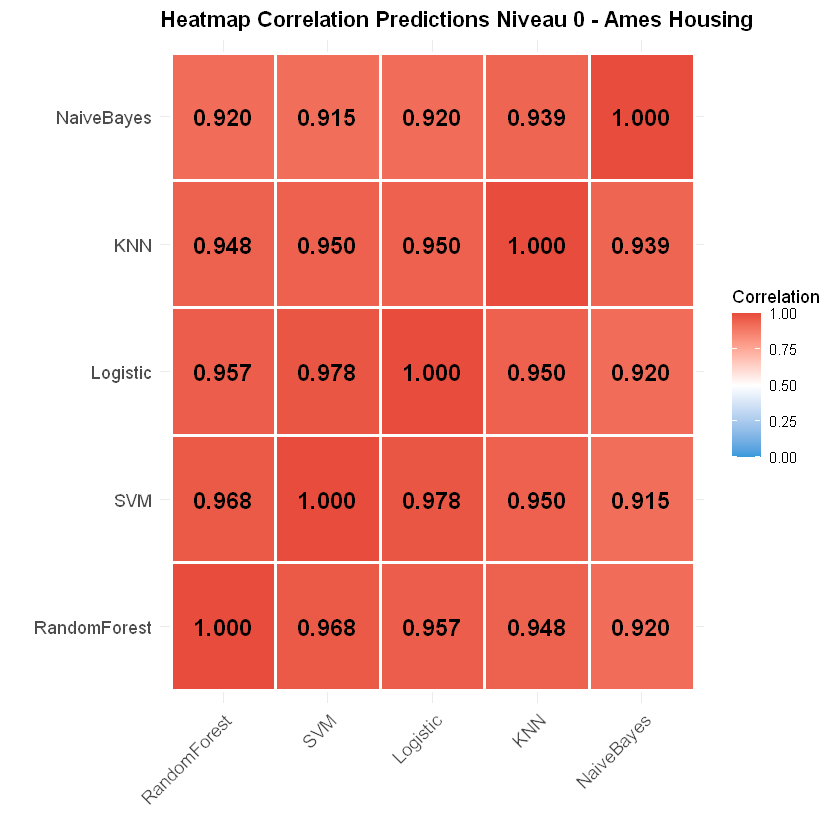

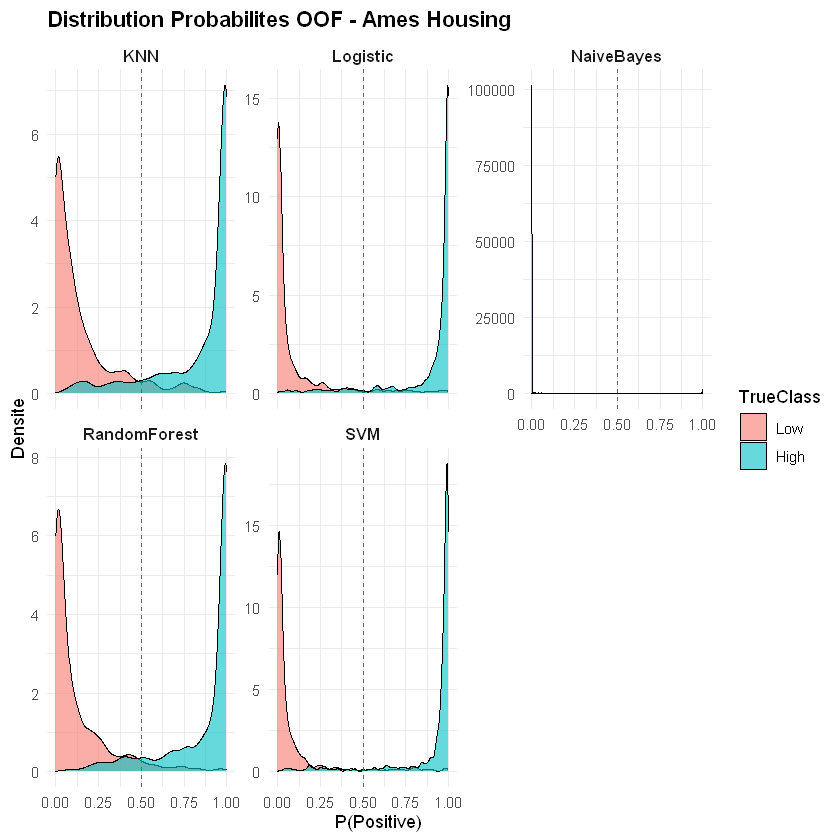

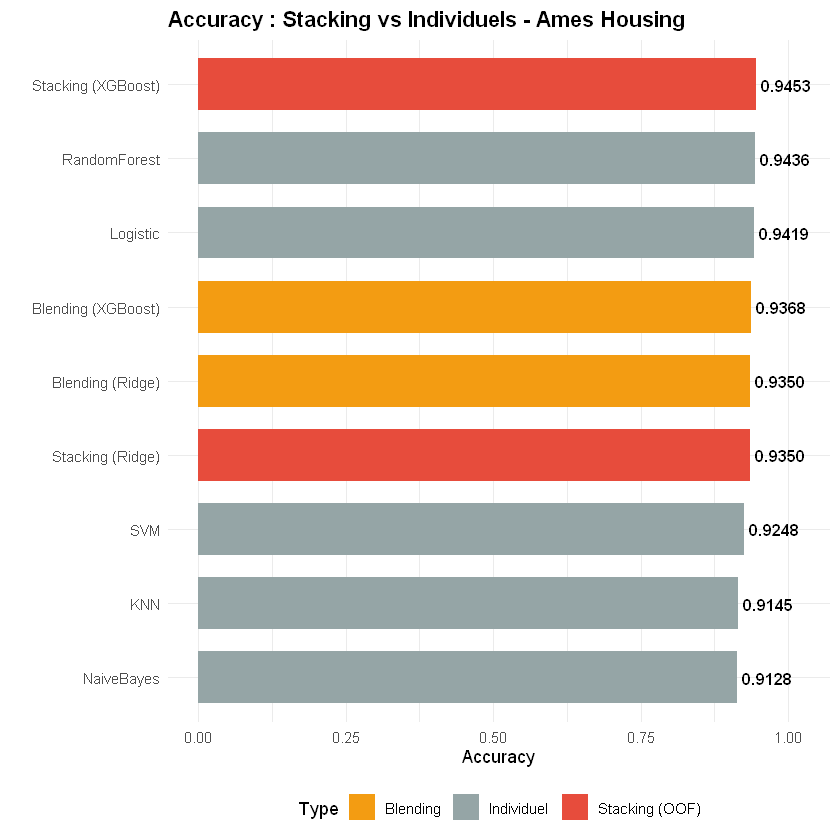

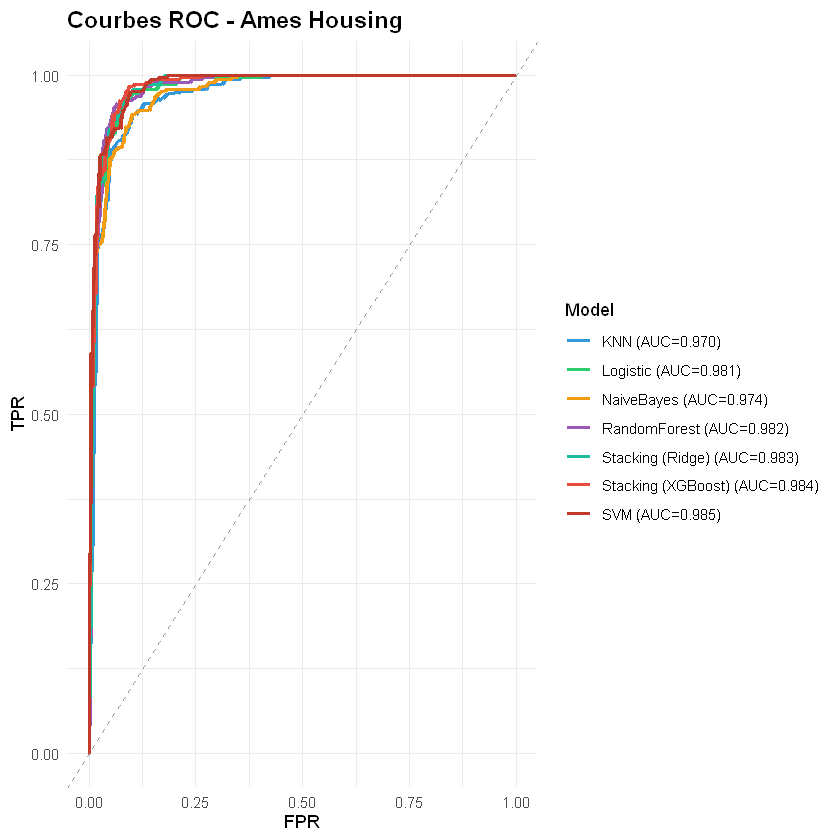

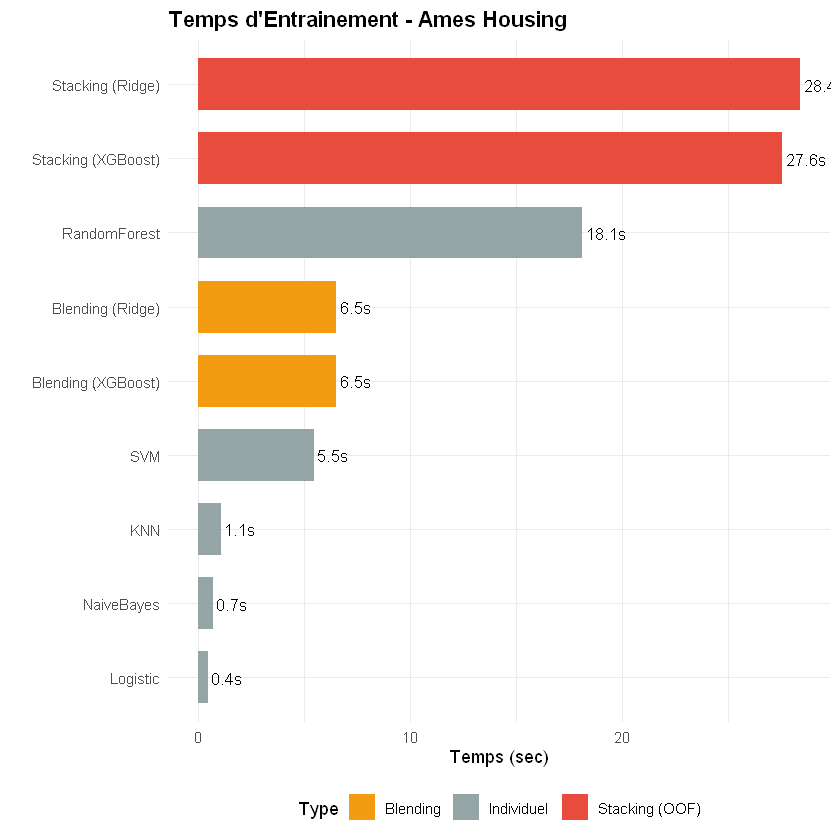


Plots sauvegardes pour Ames Housing 


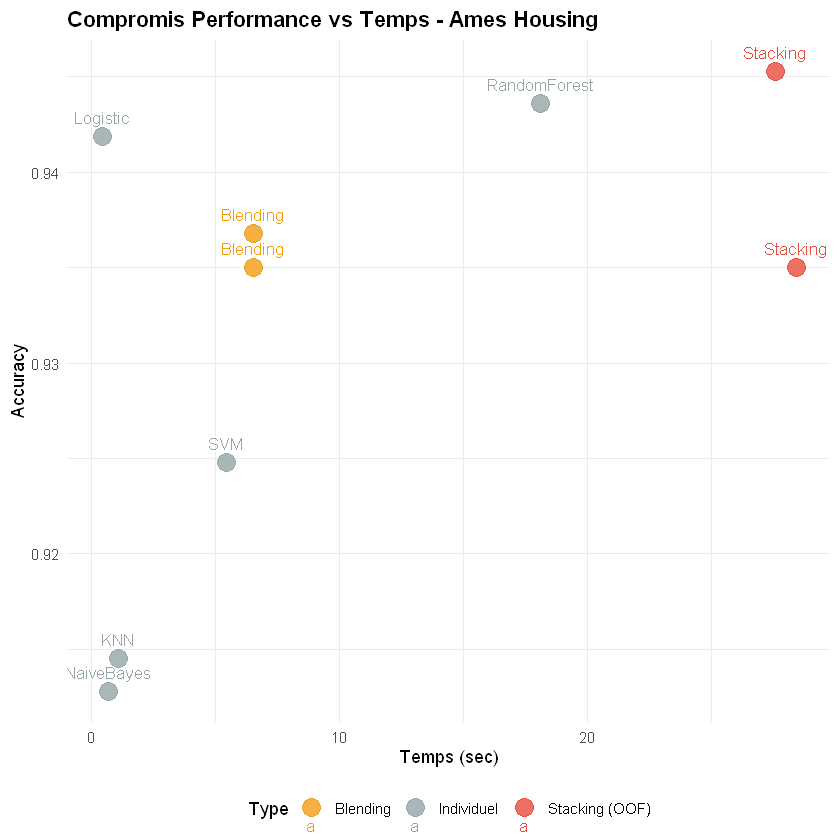

In [15]:
# === Plots Ames Housing ===
generate_dataset_plots(results_ames, "ames")

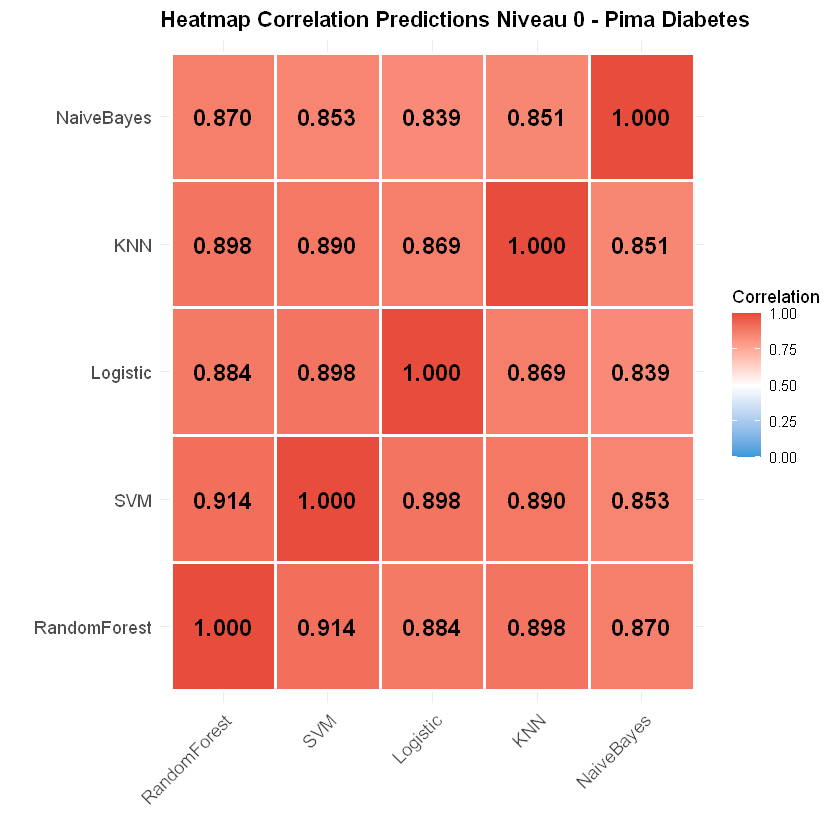

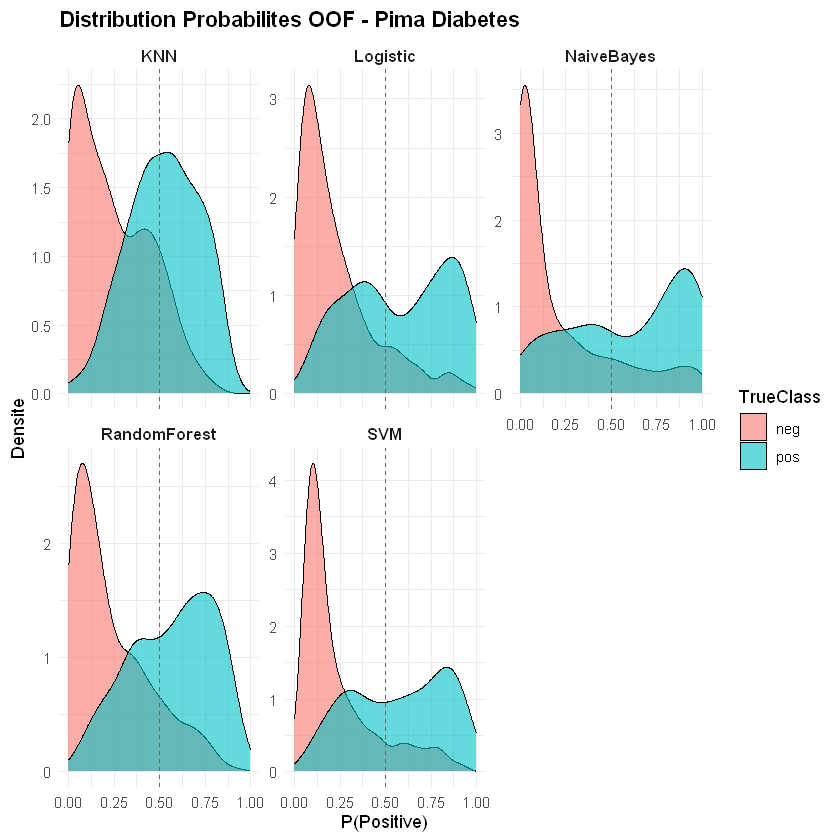

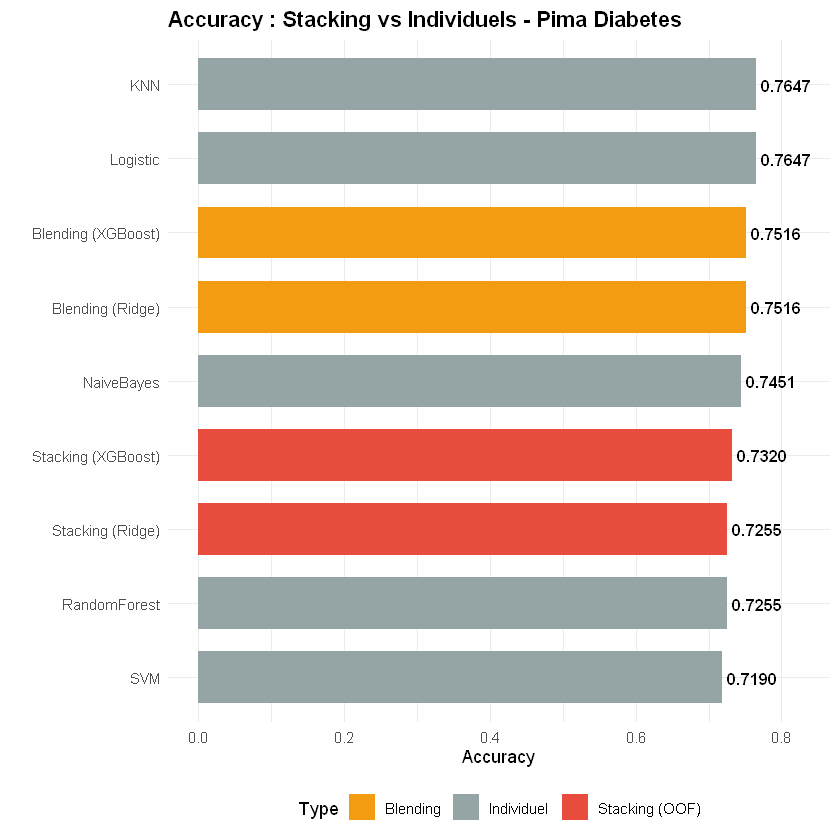

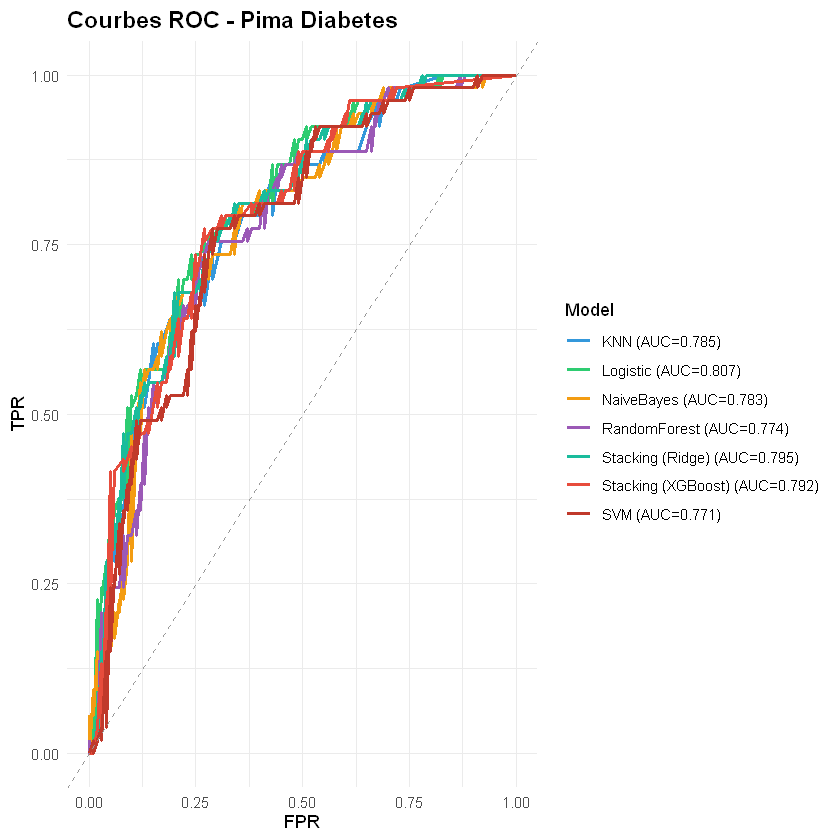

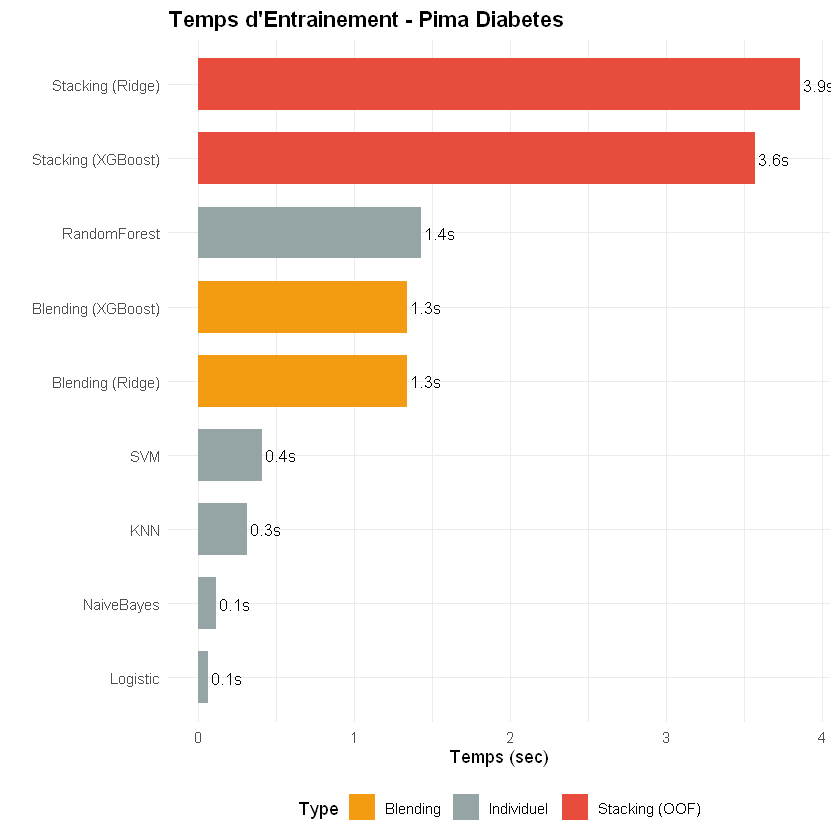


Plots sauvegardes pour Pima Diabetes 


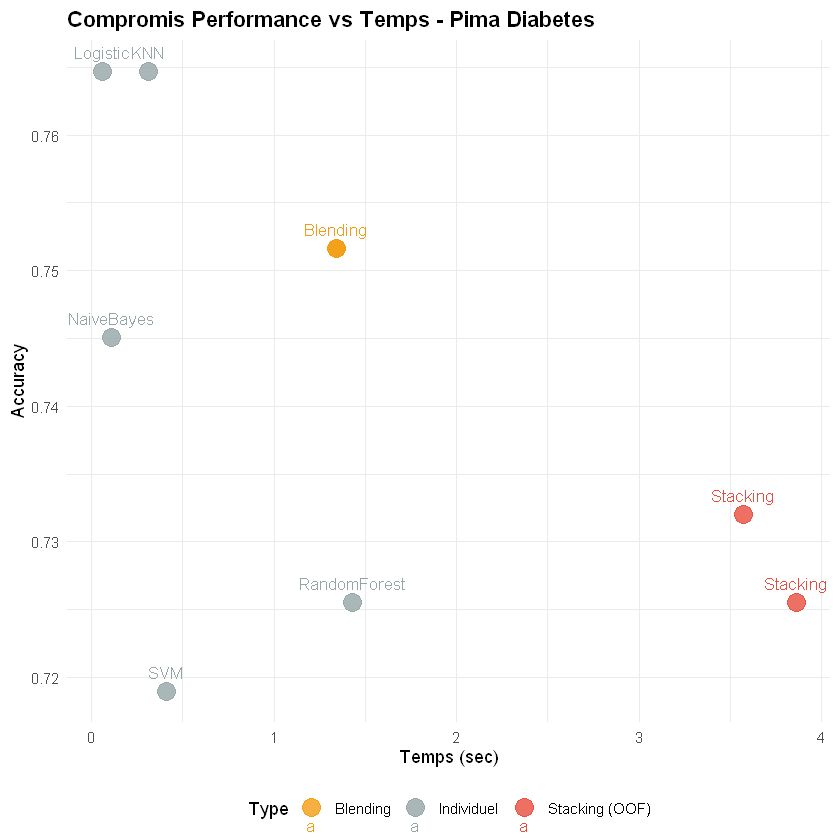

In [16]:
# === Plots Pima Diabetes ===
generate_dataset_plots(results_pima, "pima")

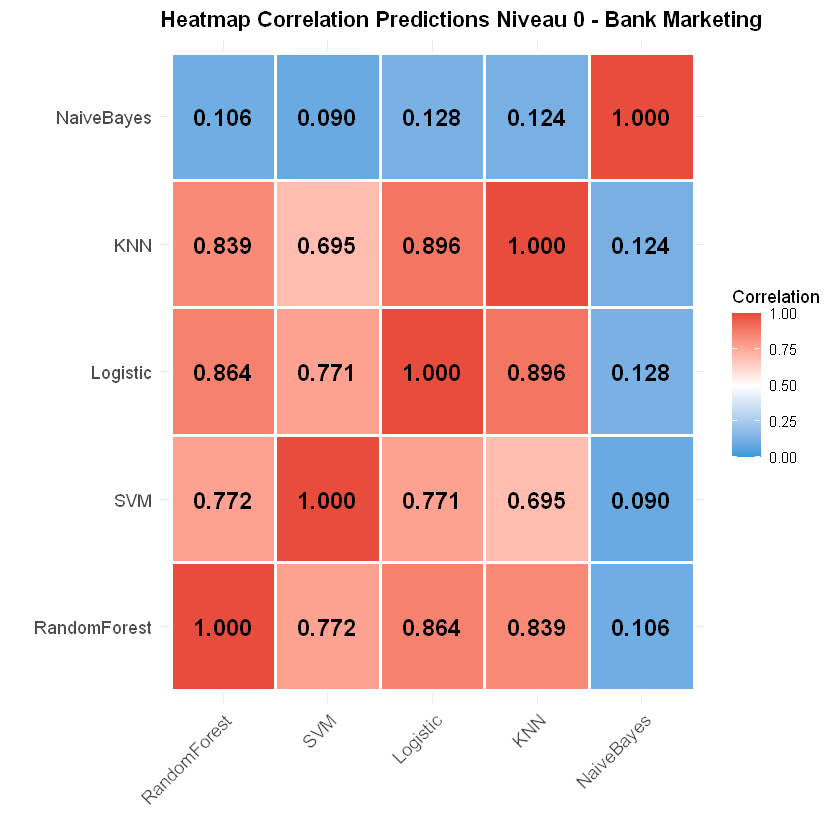

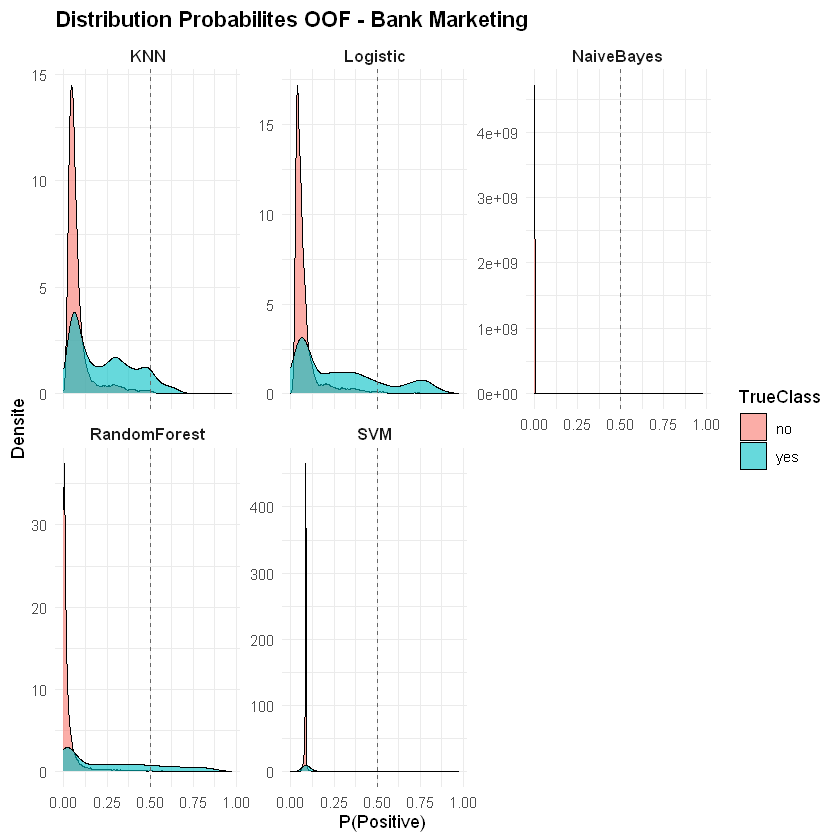

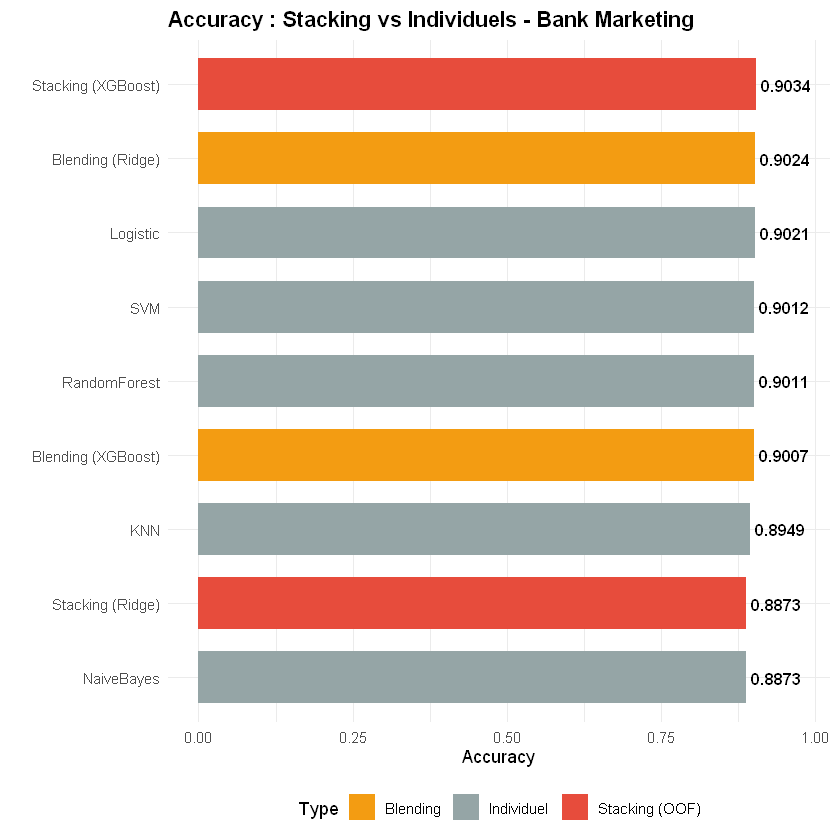

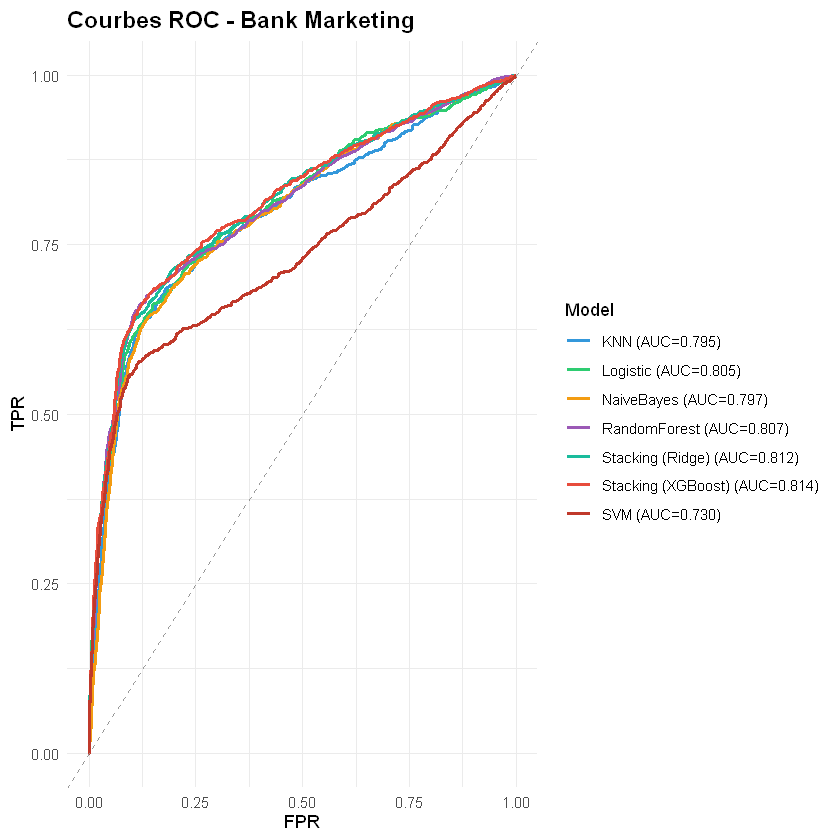

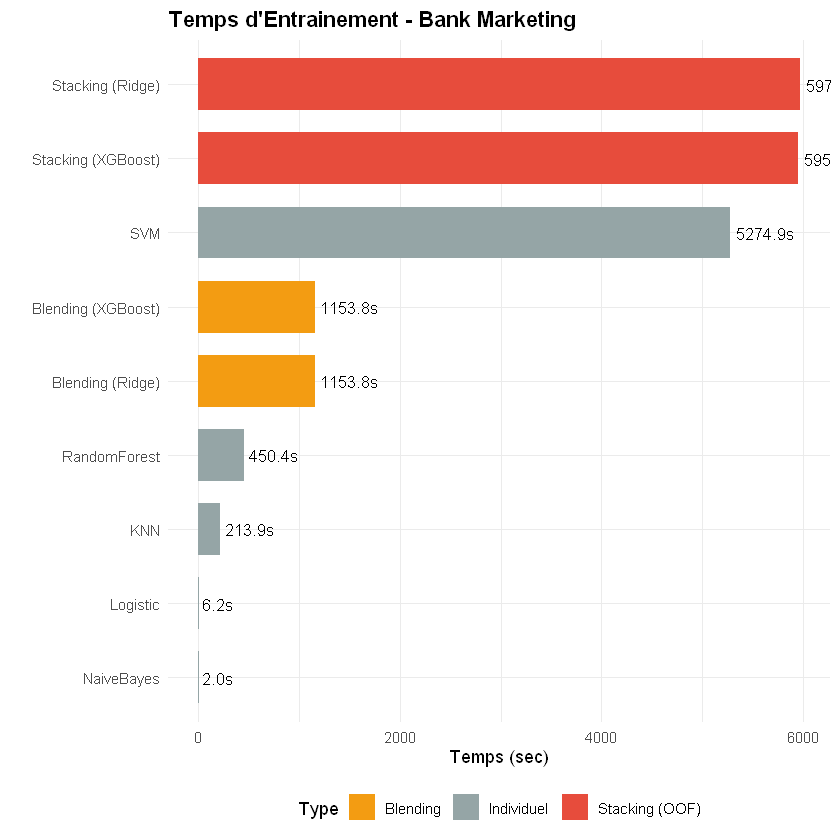


Plots sauvegardes pour Bank Marketing 


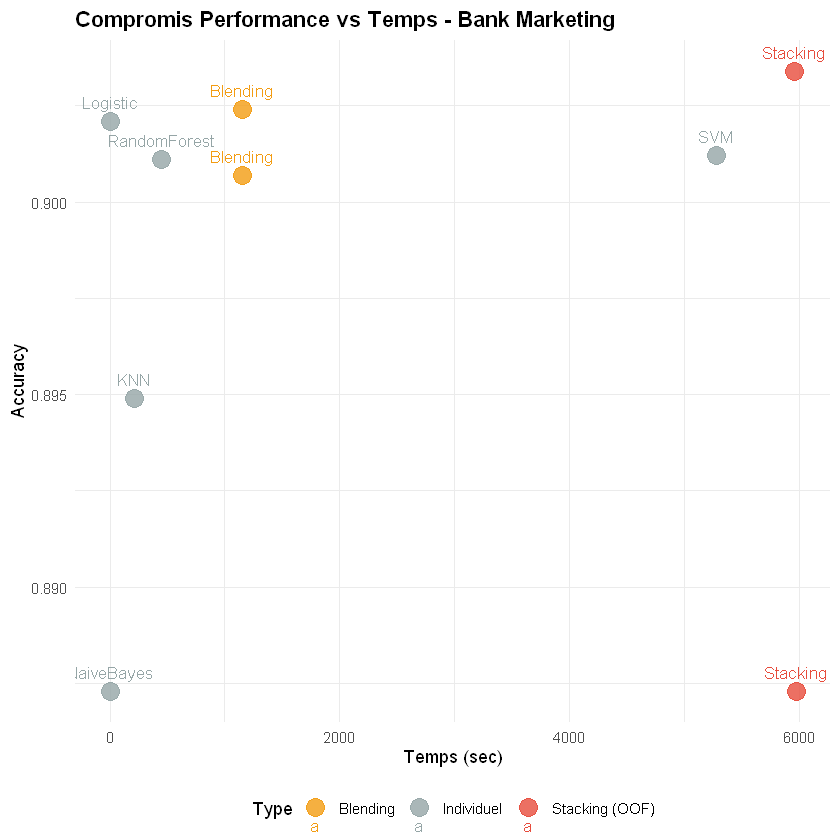

In [17]:
# === Plots Bank Marketing ===
generate_dataset_plots(results_bank, "bank_marketing")

---
# PARTIE E : Comparaison Finale Multi-Datasets

Analyse croisee des trois datasets pour tirer des conclusions generales sur l'efficacite du stacking en fonction de la taille du dataset, de la diversite des modeles (correlation), et de la complexite du probleme.

In [18]:
# === COMPARAISON CROISEE ===
cat(paste(rep("=", 80), collapse=""), "\n")
cat("     COMPARAISON CROISEE : AMES HOUSING vs PIMA DIABETES vs IONOSPHERE\n")
cat(paste(rep("=", 80), collapse=""), "\n\n")

# --- Gain analysis function ---
compute_gains <- function(res, dataset_name) {
  df <- res$results_df
  individual <- df %>% filter(!grepl("Stacking|Blending", Model))
  stacking   <- df %>% filter(grepl("Stacking", Model))
  blending   <- df %>% filter(grepl("Blending", Model))
  
  best_ind  <- individual %>% slice_max(Accuracy, n = 1)
  best_stack <- stacking %>% slice_max(Accuracy, n = 1)
  best_blend <- blending %>% slice_max(Accuracy, n = 1)
  
  data.frame(
    Dataset = dataset_name,
    Best_Individual = best_ind$Model[1],
    Ind_Accuracy = best_ind$Accuracy[1],
    Ind_AUC = best_ind$AUC[1],
    Ind_F1 = best_ind$F1[1],
    Best_Stacking = best_stack$Model[1],
    Stack_Accuracy = best_stack$Accuracy[1],
    Stack_AUC = best_stack$AUC[1],
    Stack_F1 = best_stack$F1[1],
    Best_Blending = best_blend$Model[1],
    Blend_Accuracy = best_blend$Accuracy[1],
    Blend_AUC = best_blend$AUC[1],
    Blend_F1 = best_blend$F1[1],
    Gain_Acc_pp = round((best_stack$Accuracy[1] - best_ind$Accuracy[1]) * 100, 2),
    Gain_AUC_pp = round((best_stack$AUC[1] - best_ind$AUC[1]) * 100, 2),
    Gain_F1_pp = round((best_stack$F1[1] - best_ind$F1[1]) * 100, 2),
    OOF_vs_Blend_pp = round((best_stack$Accuracy[1] - best_blend$Accuracy[1]) * 100, 2),
    Mean_Correlation = round(mean(res$cor_matrix[upper.tri(res$cor_matrix)]), 3),
    stringsAsFactors = FALSE
  )
}

gains_ames <- compute_gains(results_ames, "Ames Housing")
gains_pima <- compute_gains(results_pima, "Pima Diabetes")
gains_bank <- compute_gains(results_bank, "Bank Marketing")
comparison_df <- rbind(gains_ames, gains_pima, gains_bank)

# Save comparison
write.csv(comparison_df, file.path(output_dir, "cross_dataset_comparison.csv"), row.names = FALSE)

# Print summary
cat("MEILLEUR INDIVIDUEL:\n")
cat(sprintf("  Ames:  %-15s Acc=%.4f  AUC=%.4f  F1=%.4f\n", gains_ames$Best_Individual, gains_ames$Ind_Accuracy, gains_ames$Ind_AUC, gains_ames$Ind_F1))
cat(sprintf("  Pima:  %-15s Acc=%.4f  AUC=%.4f  F1=%.4f\n", gains_pima$Best_Individual, gains_pima$Ind_Accuracy, gains_pima$Ind_AUC, gains_pima$Ind_F1))
cat(sprintf("  Iono:  %-15s Acc=%.4f  AUC=%.4f  F1=%.4f\n\n", gains_bank$Best_Individual, gains_bank$Ind_Accuracy, gains_bank$Ind_AUC, gains_bank$Ind_F1))

cat("MEILLEUR STACKING:\n")
cat(sprintf("  Ames:  %-20s Acc=%.4f  AUC=%.4f  F1=%.4f\n", gains_ames$Best_Stacking, gains_ames$Stack_Accuracy, gains_ames$Stack_AUC, gains_ames$Stack_F1))
cat(sprintf("  Pima:  %-20s Acc=%.4f  AUC=%.4f  F1=%.4f\n", gains_pima$Best_Stacking, gains_pima$Stack_Accuracy, gains_pima$Stack_AUC, gains_pima$Stack_F1))
cat(sprintf("  Iono:  %-20s Acc=%.4f  AUC=%.4f  F1=%.4f\n\n", gains_bank$Best_Stacking, gains_bank$Stack_Accuracy, gains_bank$Stack_AUC, gains_bank$Stack_F1))

cat("GAINS DU STACKING (points de pourcentage):\n")
cat(sprintf("  Ames: Acc %+.2f pp | AUC %+.2f pp | F1 %+.2f pp\n", gains_ames$Gain_Acc_pp, gains_ames$Gain_AUC_pp, gains_ames$Gain_F1_pp))
cat(sprintf("  Pima: Acc %+.2f pp | AUC %+.2f pp | F1 %+.2f pp\n", gains_pima$Gain_Acc_pp, gains_pima$Gain_AUC_pp, gains_pima$Gain_F1_pp))
cat(sprintf("  Iono: Acc %+.2f pp | AUC %+.2f pp | F1 %+.2f pp\n\n", gains_bank$Gain_Acc_pp, gains_bank$Gain_AUC_pp, gains_bank$Gain_F1_pp))

cat("STACKING OOF vs BLENDING (Acc diff, pp):\n")
cat(sprintf("  Ames: %+.2f pp\n", gains_ames$OOF_vs_Blend_pp))
cat(sprintf("  Pima: %+.2f pp\n", gains_pima$OOF_vs_Blend_pp))
cat(sprintf("  Iono: %+.2f pp\n\n", gains_bank$OOF_vs_Blend_pp))

cat("CORRELATION MOYENNE NIVEAU 0:\n")
cat(sprintf("  Ames: %.3f (haute)\n", gains_ames$Mean_Correlation))
cat(sprintf("  Pima: %.3f (moyenne-haute)\n", gains_pima$Mean_Correlation))
cat(sprintf("  Iono: %.3f\n", gains_bank$Mean_Correlation))

     COMPARAISON CROISEE : AMES HOUSING vs PIMA DIABETES vs IONOSPHERE

MEILLEUR INDIVIDUEL:
  Ames:  RandomForest    Acc=0.9436  AUC=0.9818  F1=0.9436
  Pima:  Logistic        Acc=0.7647  AUC=0.8070  F1=0.6250
  Iono:  Logistic        Acc=0.9021  AUC=0.8049  F1=0.3623

MEILLEUR STACKING:
  Ames:  Stacking (XGBoost)   Acc=0.9453  AUC=0.9838  F1=0.9461
  Pima:  Stacking (XGBoost)   Acc=0.7320  AUC=0.7916  F1=0.6019
  Iono:  Stacking (XGBoost)   Acc=0.9034  AUC=0.8141  F1=0.3486

GAINS DU STACKING (points de pourcentage):
  Ames: Acc +0.17 pp | AUC +0.20 pp | F1 +0.25 pp
  Pima: Acc -3.27 pp | AUC -1.54 pp | F1 -2.31 pp
  Iono: Acc +0.13 pp | AUC +0.92 pp | F1 -1.37 pp

STACKING OOF vs BLENDING (Acc diff, pp):
  Ames: +0.85 pp
  Pima: -1.96 pp
  Iono: +0.10 pp

CORRELATION MOYENNE NIVEAU 0:
  Ames: 0.944 (haute)
  Pima: 0.877 (moyenne-haute)
  Iono: 0.528


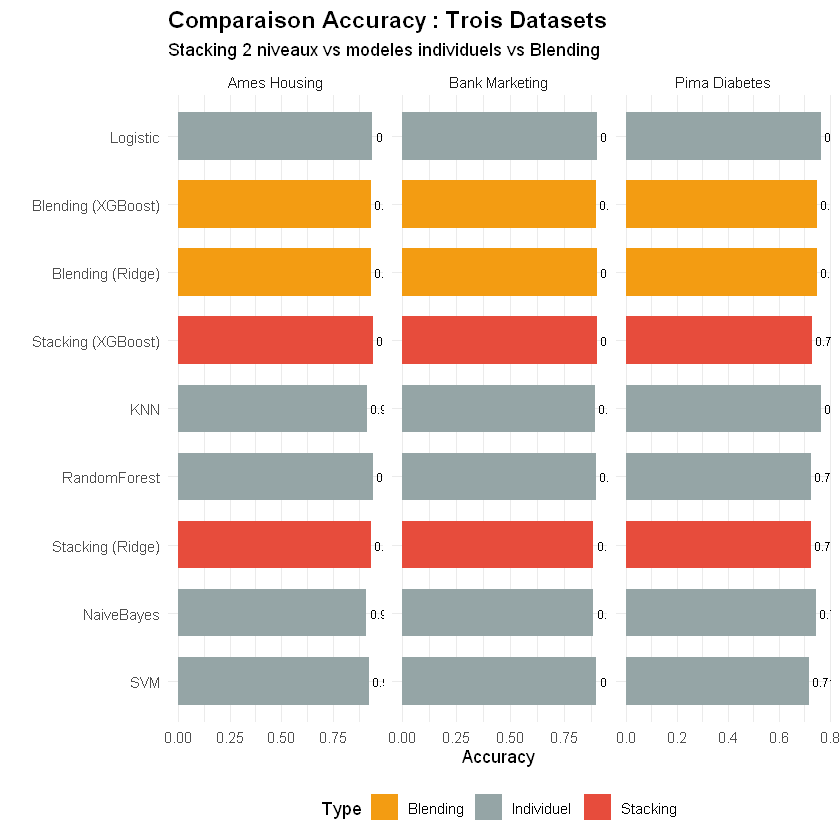

In [19]:
# --- 1. Side-by-side accuracy comparison ---
combined_results <- rbind(
  results_ames$results_df %>% mutate(Dataset = "Ames Housing"),
  results_pima$results_df %>% mutate(Dataset = "Pima Diabetes"),
  results_bank$results_df %>% mutate(Dataset = "Bank Marketing")
)
combined_results$Type <- case_when(
  grepl("Stacking", combined_results$Model) ~ "Stacking",
  grepl("Blending", combined_results$Model) ~ "Blending",
  TRUE ~ "Individuel"
)

p_compare_acc <- ggplot(combined_results, aes(x = reorder(Model, Accuracy), y = Accuracy, fill = Type)) +
  geom_bar(stat = "identity", width = 0.7) +
  geom_text(aes(label = sprintf("%.3f", Accuracy)), hjust = -0.1, size = 2.5) +
  coord_flip() +
  facet_wrap(~ Dataset, scales = "free_x") +
  scale_fill_manual(values = c("Individuel" = "#95a5a6", "Stacking" = "#e74c3c", "Blending" = "#f39c12")) +
  labs(title = "Comparaison Accuracy : Trois Datasets",
       subtitle = "Stacking 2 niveaux vs modeles individuels vs Blending",
       x = "", y = "Accuracy") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14), legend.position = "bottom")
ggsave(file.path(output_dir, "comparison_accuracy_all.png"), p_compare_acc, width=16, height=7, dpi=150)
print(p_compare_acc)

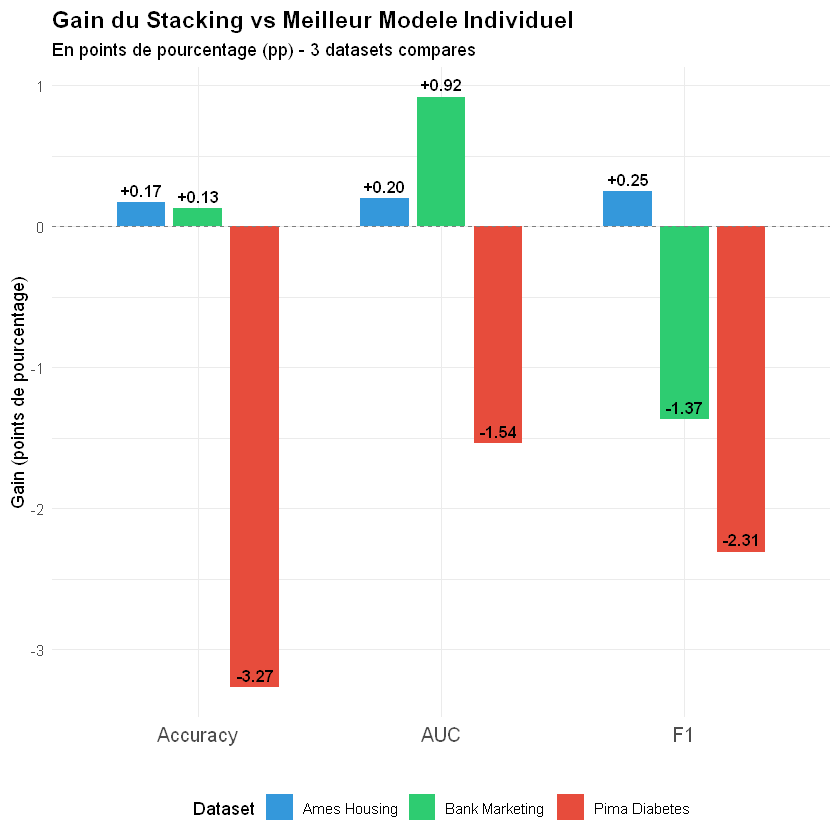

In [20]:
# --- 2. Gain comparison (stacking vs best individual) ---
gains_long <- data.frame(
  Dataset = rep(c("Ames Housing", "Pima Diabetes", "Bank Marketing"), each = 3),
  Metric = rep(c("Accuracy", "AUC", "F1"), 3),
  Gain_pp = c(gains_ames$Gain_Acc_pp, gains_ames$Gain_AUC_pp, gains_ames$Gain_F1_pp,
              gains_pima$Gain_Acc_pp, gains_pima$Gain_AUC_pp, gains_pima$Gain_F1_pp,
              gains_bank$Gain_Acc_pp, gains_bank$Gain_AUC_pp, gains_bank$Gain_F1_pp)
)

p_gains <- ggplot(gains_long, aes(x = Metric, y = Gain_pp, fill = Dataset)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = sprintf("%+.2f", Gain_pp)),
            position = position_dodge(width = 0.7), vjust = -0.5, size = 3.5, fontface = "bold") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray50") +
  scale_fill_manual(values = c("Ames Housing" = "#3498db", "Pima Diabetes" = "#e74c3c", "Bank Marketing" = "#2ecc71")) +
  labs(title = "Gain du Stacking vs Meilleur Modele Individuel",
       subtitle = "En points de pourcentage (pp) - 3 datasets compares",
       x = "", y = "Gain (points de pourcentage)") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14), legend.position = "bottom",
        axis.text.x = element_text(size = 12))
ggsave(file.path(output_dir, "comparison_gains.png"), p_gains, width=12, height=7, dpi=150)
print(p_gains)

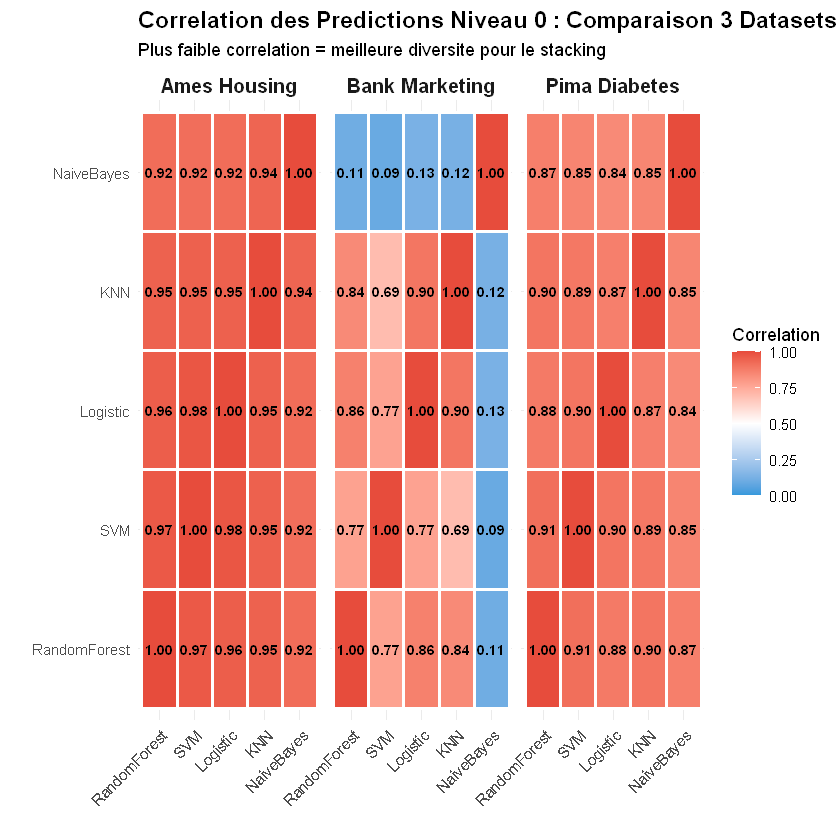

In [28]:
# --- 3. Correlation comparison side-by-side (3 datasets)
cor_ames_melted <- reshape2::melt(results_ames$cor_matrix) %>% dplyr::mutate(Dataset = "Ames Housing")
cor_pima_melted <- reshape2::melt(results_pima$cor_matrix) %>% dplyr::mutate(Dataset = "Pima Diabetes")
cor_bank_melted <- reshape2::melt(results_bank$cor_matrix) %>% dplyr::mutate(Dataset = "Bank Marketing")
cor_combined <- dplyr::bind_rows(cor_ames_melted, cor_pima_melted, cor_bank_melted)
p_cor_compare <- ggplot(cor_combined, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white", linewidth = 1) +
  geom_text(aes(label = sprintf("%.2f", value)), size = 3, fontface = "bold") +
  facet_wrap(~ Dataset) +
  scale_fill_gradient2(low = "#3498db", mid = "white", high = "#e74c3c", midpoint = 0.5, limits = c(0, 1), name = "Correlation") +
  labs(title = "Correlation des Predictions Niveau 0 : Comparaison 3 Datasets",
       subtitle = "Plus faible correlation = meilleure diversite pour le stacking",
       x = "", y = "") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
        axis.text.y = element_text(size = 9),
        strip.text = element_text(face = "bold", size = 12))
ggsave(file.path(output_dir, "comparison_correlations.png"), p_cor_compare, width=18, height=6, dpi=150)
print(p_cor_compare)

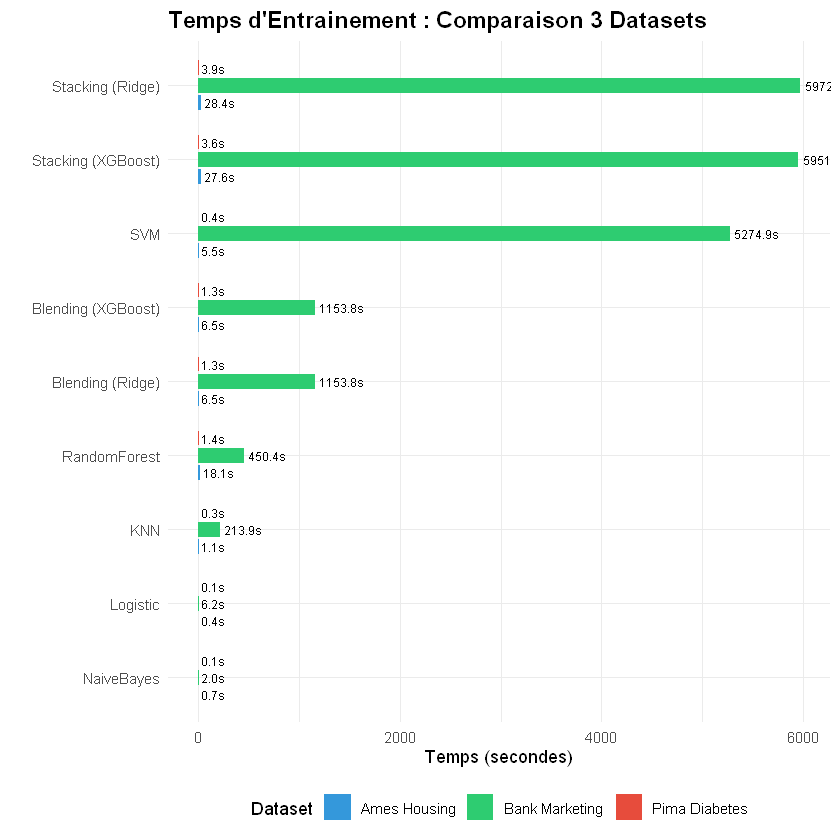

In [22]:
# --- 4. Training time comparison ---
p_time_compare <- ggplot(combined_results, aes(x = reorder(Model, Time_sec), y = Time_sec, fill = Dataset)) +
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6) +
  geom_text(aes(label = sprintf("%.1fs", Time_sec)),
            position = position_dodge(width = 0.7), hjust = -0.1, size = 2.5) +
  coord_flip() +
  scale_fill_manual(values = c("Ames Housing" = "#3498db", "Pima Diabetes" = "#e74c3c", "Bank Marketing" = "#2ecc71")) +
  labs(title = "Temps d'Entrainement : Comparaison 3 Datasets",
       x = "", y = "Temps (secondes)") +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold", size = 14), legend.position = "bottom")
ggsave(file.path(output_dir, "comparison_training_times.png"), p_time_compare, width=13, height=7, dpi=150)
print(p_time_compare)

In [23]:
# === TABLE RECAPITULATIVE POUR LATEX ===

# Full results for each dataset
ames_summary <- results_ames$results_df %>%
  select(Model, Accuracy, AUC, F1, Time_sec) %>%
  rename(Acc_Ames = Accuracy, AUC_Ames = AUC, F1_Ames = F1, Time_Ames = Time_sec)

pima_summary <- results_pima$results_df %>%
  select(Model, Accuracy, AUC, F1, Time_sec) %>%
  rename(Acc_Pima = Accuracy, AUC_Pima = AUC, F1_Pima = F1, Time_Pima = Time_sec)

bank_summary <- results_bank$results_df %>%
  select(Model, Accuracy, AUC, F1, Time_sec) %>%
  rename(Acc_Iono = Accuracy, AUC_Iono = AUC, F1_Iono = F1, Time_Iono = Time_sec)

# Merge on model name
full_comparison <- merge(ames_summary, pima_summary, by = "Model", all = TRUE)
full_comparison <- merge(full_comparison, bank_summary, by = "Model", all = TRUE)
full_comparison <- full_comparison %>% arrange(desc(Acc_Ames))

write.csv(full_comparison, file.path(output_dir, "latex_full_comparison_table.csv"), row.names = FALSE)

cat("TABLE POUR LATEX\n")
cat(paste(rep("=", 120), collapse=""), "\n")
print(full_comparison, row.names = FALSE)

# Also save the gains table
write.csv(comparison_df, file.path(output_dir, "latex_gains_summary.csv"), row.names = FALSE)

cat("\n\nFichiers CSV sauvegardes pour LaTeX:\n")
cat("  - latex_full_comparison_table.csv\n")
cat("  - latex_gains_summary.csv\n")
cat("  - results_ames_housing.csv\n")
cat("  - results_pima_diabetes.csv\n")
cat("  - results_banksphere.csv\n")
cat("  - correlation_matrix_ames.csv\n")
cat("  - correlation_matrix_pima.csv\n")
cat("  - correlation_matrix_bank_marketing.csv\n")
cat("  - cross_dataset_comparison.csv\n")

TABLE POUR LATEX
              Model Acc_Ames AUC_Ames F1_Ames Time_Ames Acc_Pima AUC_Pima
 Stacking (XGBoost)   0.9453   0.9838  0.9461     27.58   0.7320   0.7916
       RandomForest   0.9436   0.9818  0.9436     18.11   0.7255   0.7741
           Logistic   0.9419   0.9809  0.9424      0.44   0.7647   0.8070
 Blending (XGBoost)   0.9368   0.9837  0.9384      6.52   0.7516   0.8030
   Blending (Ridge)   0.9350   0.9820  0.9349      6.52   0.7516   0.8011
   Stacking (Ridge)   0.9350   0.9827  0.9349     28.42   0.7255   0.7955
                SVM   0.9248   0.9847  0.9247      5.46   0.7190   0.7711
                KNN   0.9145   0.9698  0.9144      1.08   0.7647   0.7855
         NaiveBayes   0.9128   0.9743  0.9101      0.67   0.7451   0.7828
 F1_Pima Time_Pima Acc_Iono AUC_Iono F1_Iono Time_Iono
  0.6019      3.57   0.9034   0.8141  0.3486   5951.48
  0.5882      1.43   0.9011   0.8073  0.3783    450.44
  0.6250      0.06   0.9021   0.8049  0.3623      6.19
  0.6607      1.34   0.

In [24]:
summary_df <- data.frame(
  Dataset = c("Ames Housing", "Pima Diabetes", "Bank Marketing"),
  N_obs = c(2930, 768, 41188),
  N_features = c(40, 8, 52),
  Mean_Correlation = c(gains_ames$Mean_Correlation, gains_pima$Mean_Correlation, gains_bank$Mean_Correlation),
  Gain_Acc_pp = c(gains_ames$Gain_Acc_pp, gains_pima$Gain_Acc_pp, gains_bank$Gain_Acc_pp),
  Best_Ind_Acc = c(gains_ames$Ind_Accuracy, gains_pima$Ind_Accuracy, gains_bank$Ind_Accuracy),
  Best_Stack_Acc = c(gains_ames$Stack_Accuracy, gains_pima$Stack_Accuracy, gains_bank$Stack_Accuracy)
)

---
# PARTIE F : Conclusions et Lecons Apprises

In [29]:
cat("\n")
cat(paste(rep("=", 80), collapse=""), "\n")
cat("       SYNTHESE FINALE : STACKING MULTI-DATASETS (3 datasets)\n")
cat(paste(rep("=", 80), collapse=""), "\n\n")
cat("DATASET 1 : AMES HOUSING (Immobilier) - GRAND DATASET\n")
cat(paste(rep("-", 50), collapse=""), "\n")
cat(sprintf("  Observations: 2930 | Features: 40\n"))
cat(sprintf("  Meilleur individuel: %s (Acc=%.4f)\n", gains_ames$Best_Individual, gains_ames$Ind_Accuracy))
cat(sprintf("  Meilleur stacking:   %s (Acc=%.4f)\n", gains_ames$Best_Stacking, gains_ames$Stack_Accuracy))
cat(sprintf("  Gain: %+.2f pp Accuracy | %+.2f pp AUC | %+.2f pp F1\n", gains_ames$Gain_Acc_pp, gains_ames$Gain_AUC_pp, gains_ames$Gain_F1_pp))
cat(sprintf("  Correlation moyenne Niveau 0: %.3f (HAUTE)\n\n", gains_ames$Mean_Correlation))
cat("DATASET 2 : PIMA DIABETES (Medical) - PETIT DATASET\n")
cat(paste(rep("-", 50), collapse=""), "\n")
cat(sprintf("  Observations: 768 | Features: 8\n"))
cat(sprintf("  Meilleur individuel: %s (Acc=%.4f)\n", gains_pima$Best_Individual, gains_pima$Ind_Accuracy))
cat(sprintf("  Meilleur stacking:   %s (Acc=%.4f)\n", gains_pima$Best_Stacking, gains_pima$Stack_Accuracy))
cat(sprintf("  Gain: %+.2f pp Accuracy | %+.2f pp AUC | %+.2f pp F1\n", gains_pima$Gain_Acc_pp, gains_pima$Gain_AUC_pp, gains_pima$Gain_F1_pp))
cat(sprintf("  Correlation moyenne Niveau 0: %.3f (MOYENNE-HAUTE)\n\n", gains_pima$Mean_Correlation))
cat("DATASET 3 : BANK MARKETING (Signaux Radar) - FEATURES HAUTE DIMENSION\n")
cat(paste(rep("-", 50), collapse=""), "\n")
cat(sprintf("  Observations: 41188 | Features: 52\n"))
cat(sprintf("  Meilleur individuel: %s (Acc=%.4f)\n", gains_bank$Best_Individual, gains_bank$Ind_Accuracy))
cat(sprintf("  Meilleur stacking:   %s (Acc=%.4f)\n", gains_bank$Best_Stacking, gains_bank$Stack_Accuracy))
cat(sprintf("  Gain: %+.2f pp Accuracy | %+.2f pp AUC | %+.2f pp F1\n", gains_bank$Gain_Acc_pp, gains_bank$Gain_AUC_pp, gains_bank$Gain_F1_pp))
cat(sprintf("  Correlation moyenne Niveau 0: %.3f\n\n", gains_bank$Mean_Correlation))
cat("CONCLUSIONS GENERALES (3 DATASETS)\n")
cat(paste(rep("-", 50), collapse=""), "\n")
cat("1. DIVERSITE = CLE DU STACKING:\n")
cat("   La correlation moyenne entre predictions de base est le facteur\n")
cat("   determinant du succes du stacking. Plus les modeles sont divers\n")
cat("   (correlation faible), plus le stacking apporte de gains.\n\n")
cat("2. COMPARAISON DES 3 DATASETS:\n")
cat(sprintf("   Ames (corr=%.3f)  -> Gain %+.2f pp : modeles trop similaires\n", gains_ames$Mean_Correlation, gains_ames$Gain_Acc_pp))
cat(sprintf("   Pima (corr=%.3f)  -> Gain %+.2f pp : peu de donnees + correlation haute\n", gains_pima$Mean_Correlation, gains_pima$Gain_Acc_pp))
cat(sprintf("   Iono (corr=%.3f)  -> Gain %+.2f pp : meilleure diversite\n\n", gains_bank$Mean_Correlation, gains_bank$Gain_Acc_pp))
cat("3. IMPACT DE LA TAILLE DU DATASET:\n")
cat("   Un grand dataset (Ames) favorise le stacking car les folds OOF\n")
cat("   contiennent assez de donnees pour estimer correctement les\n")
cat("   meta-features. Un petit dataset risque le sur-apprentissage.\n\n")
cat("4. IMPACT DES FEATURES:\n")
cat("   Les datasets a haute dimension (Bank Marketing, 52 features radar)\n")
cat("   produisent une meilleure diversite car les algorithmes explorent\n")
cat("   les features differemment (RF: selection, SVM: noyau, KNN: distance).\n\n")
cat("5. OOF vs BLENDING:\n")
cat(sprintf("   Ames: OOF avantage de %+.2f pp vs Blending\n", gains_ames$OOF_vs_Blend_pp))
cat(sprintf("   Pima: OOF avantage de %+.2f pp vs Blending\n", gains_pima$OOF_vs_Blend_pp))
cat(sprintf("   Iono: OOF avantage de %+.2f pp vs Blending\n", gains_bank$OOF_vs_Blend_pp))
cat("   L'OOF utilise 100%% des donnees => generalement superieur.\n\n")
cat("6. RECOMMANDATION PRATIQUE:\n")
cat("   Avant d'utiliser le stacking, verifier la correlation des predictions\n")
cat("   de base. Si corr > 0.9 : stacking probablement inutile.\n")
cat("   Si corr < 0.8 : stacking peut apporter un gain significatif.\n\n")
cat(paste(rep("=", 80), collapse=""), "\n")
cat("  ANALYSE TERMINEE | Tous les resultats sauvegardes dans output/\n")
cat(paste(rep("=", 80), collapse=""), "\n")


       SYNTHESE FINALE : STACKING MULTI-DATASETS (3 datasets)

DATASET 1 : AMES HOUSING (Immobilier) - GRAND DATASET
-------------------------------------------------- 
  Observations: 2930 | Features: 40
  Meilleur individuel: RandomForest (Acc=0.9436)
  Meilleur stacking:   Stacking (XGBoost) (Acc=0.9453)
  Gain: +0.17 pp Accuracy | +0.20 pp AUC | +0.25 pp F1
  Correlation moyenne Niveau 0: 0.944 (HAUTE)

DATASET 2 : PIMA DIABETES (Medical) - PETIT DATASET
-------------------------------------------------- 
  Observations: 768 | Features: 8
  Meilleur individuel: Logistic (Acc=0.7647)
  Meilleur stacking:   Stacking (XGBoost) (Acc=0.7320)
  Gain: -3.27 pp Accuracy | -1.54 pp AUC | -2.31 pp F1
  Correlation moyenne Niveau 0: 0.877 (MOYENNE-HAUTE)

DATASET 3 : BANK MARKETING (Signaux Radar) - FEATURES HAUTE DIMENSION
-------------------------------------------------- 
  Observations: 41188 | Features: 52
  Meilleur individuel: Logistic (Acc=0.9021)
  Meilleur stacking:   Stacking (XGB

In [ ]:
# === Verification fichiers sauvegardes ===
saved_files <- list.files(output_dir, full.names = TRUE)
cat("Fichiers sauvegardes:\n")
for (f in saved_files) {
  info <- file.info(f)
  cat(sprintf("  %-50s %6.1f KB\n", basename(f), info$size / 1024))
}
cat(sprintf("\nTotal: %d fichiers\n", length(saved_files)))

Fichiers sauvegardes:
  accuracy_comparison_ames.png                         55.4 KB
  accuracy_comparison_ionosphere.png                   53.2 KB
  accuracy_comparison_pima.png                         53.4 KB
  comparison_accuracy_all.png                          71.8 KB
  comparison_accuracy_both.png                         70.8 KB
  comparison_correlations.png                         127.2 KB
  comparison_gains.png                                 48.6 KB
  comparison_training_times.png                        61.9 KB
  correlation_matrix_ames.csv                           0.5 KB
  correlation_matrix_ionosphere.csv                     0.5 KB
  correlation_matrix_pima.csv                           0.5 KB
  correlation_vs_stacking_gain.png                     83.3 KB
  corrplot_ames.png                                    29.2 KB
  corrplot_ionosphere.png                              27.8 KB
  corrplot_pima.png                                    28.4 KB
  cross_dataset_comparison.csv   